<a href="https://colab.research.google.com/github/YaninaK/churn-prediction/blob/main/notebooks/01_EDA_and_Feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прогнозирование оттока клиентов
## EDA и отбор признаков

[Ссылка на данные](https://drive.google.com/file/d/1TAVECAfnel9lPfcpfel6qXhZSW2yNqdX/view?usp=sharing)



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/YaninaK/churn-prediction.git -q

In [3]:
%cd churn-prediction

/content/churn-prediction


In [4]:
import sys
import os

sys.path.append(os.getcwd())
sys.path.append(os.path.join(os.getcwd(), "src", "churn_prediction"))

In [5]:
import pandas as pd
import numpy as np
import joblib
import tempfile
import random
import tensorflow as tf

import statsmodels.api as sm
from scipy.stats import chi2_contingency, chisquare, kstest
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

from data.make_dataset import load_data
from data.validation import train_test_data_split, train_test_split
from data.make_dataset import seq_padding, generate_dataset
from features.time_series_features import fit_transform_seq, transform_seq
from features.binary_features import map_categorical_features
from models.LSTM_model import get_LSTM_model, get_ts_embeddings_model, get_ts_embeddings

from models.embeddings_tf import (
    fit_transform_embeddings,
    transform_embeddings,
    fit_transform_one_hot_encoding,
    transform_one_hot_encoding,
)
from models.utilities import (
    get_initial_bias_and_class_weight,
    plot_loss,
    plot_metrics,
    plot_cm,
    plot_roc,
    plot_prc,
    plot_lift,
)
from data.EDA_utilities import get_correlated_features, plot_ks_test

import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
SEED = 25
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)

In [8]:
PATH = '/content/drive/MyDrive/ML_projects/06_Churn_prediction/'

## 1. Загрузка данных

In [9]:
data = load_data(PATH)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20468 entries, 0 to 20467
Data columns (total 29 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   20468 non-null  int64  
 1   annualincome                          20468 non-null  int64  
 2   calldroprate                          20468 non-null  float64
 3   callfailurerate                       20468 non-null  float64
 4   callingnum                            20468 non-null  int64  
 5   customerid                            20468 non-null  int64  
 6   customersuspended                     20468 non-null  object 
 7   education                             20468 non-null  object 
 8   gender                                20468 non-null  object 
 9   homeowner                             20468 non-null  object 
 10  maritalstatus                         20468 non-null  object 
 11  monthlybilledam

In [10]:
TARGET_NAME = 'churn'
ID = 'customerid'

## 2. EDA

In [11]:
data.nunique()

age                                       68
annualincome                            9508
calldroprate                               8
callfailurerate                            4
callingnum                              9525
customerid                              9525
customersuspended                          2
education                                  4
gender                                     2
homeowner                                  2
maritalstatus                              2
monthlybilledamount                      120
noadditionallines                          1
numberofcomplaints                         4
numberofmonthunpaid                        8
numdayscontractequipmentplanexpiring     100
occupation                                 3
penaltytoswitch                          500
state                                     50
totalminsusedinlastmonth                 500
unpaidbalance                            250
usesinternetservice                        2
usesvoices

* Признаки noadditionallines и year не изменяется - их использовать не будем.
* Данные представлены за 3 месяца.

### 2.1. Целевая переменная

In [12]:
agg = data.groupby(ID, as_index=False)[TARGET_NAME].max()
agg

,customerid,churn
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
9520,9521,0
9521,9522,0
9522,9523,1
9523,9524,0


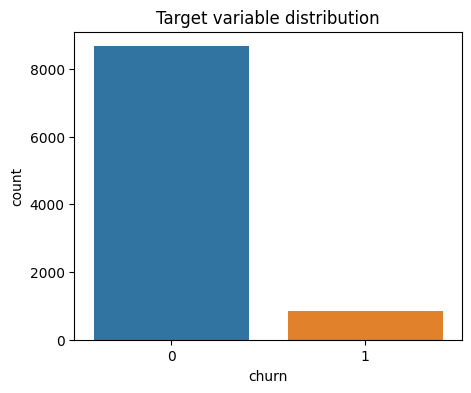

In [13]:
plt.figure(figsize=(5, 4))
sns.countplot(x=TARGET_NAME, data=agg)
plt.title('Target variable distribution')
plt.show()

In [14]:
agg[TARGET_NAME].value_counts()

0    8664
1     861
Name: churn, dtype: int64

In [15]:
agg[TARGET_NAME].value_counts(normalize=True)

0    0.909606
1    0.090394
Name: churn, dtype: float64

* Доступны данные по 9525 клиентам
* Отток клиентов составляет 9%
* Разбивку на обучающую, и тестовую выборки будем осуществляять по уникальным идентификационным номерам клиентов с сохранением пропорции между значениями целевой переменной (stratified train test split).

In [16]:
data_train, data_test = train_test_data_split(data)

In [17]:
client_data_changes = data_train.groupby(ID).nunique().mean()
client_data_changes

age                                     1.000000
annualincome                            1.000000
calldroprate                            1.000000
callfailurerate                         1.000000
callingnum                              1.000000
customersuspended                       1.000000
education                               1.000000
gender                                  1.000000
homeowner                               1.000000
maritalstatus                           1.000000
monthlybilledamount                     1.000000
noadditionallines                       1.000000
numberofcomplaints                      1.000000
numberofmonthunpaid                     1.000000
numdayscontractequipmentplanexpiring    1.000000
occupation                              1.000000
penaltytoswitch                         1.000000
state                                   1.000000
totalminsusedinlastmonth                1.000000
unpaidbalance                           1.000000
usesinternetservice 

* Значение целевой функции не изменяется во времени.
* В среднем, по клиентам доступны данные только за 2 временных промежутка.
* На заданном промежутке времени изменяются только totalcallduration и avgcallduration.

In [18]:
agg_1 = data_train.groupby(ID, as_index=False)[TARGET_NAME].max()
agg_2 = data_train.groupby(ID).agg(
    no_info_1 = ('month', lambda x: 1 if x.min() > 1 else 0),
    no_info_3 = ('month', lambda x: 1 if x.max() < 3 else 0),
    seq_len = ('totalcallduration', lambda x: len(x.tolist())),
    seq_total = ('totalcallduration', seq_padding),
    seq_avg = ('avgcallduration', seq_padding),
)
agg_2 = pd.concat([agg_2, agg_1.set_index(ID)], axis=1)
agg_2

,no_info_1,no_info_3,seq_len,seq_total,seq_avg,churn
customerid,,,,,,
1,0,1,2,"[5971, 3981, 0]","[663, 995, 0]",0
3,0,1,2,"[3122, 2769, 0]","[624, 553, 0]",0
7,0,1,2,"[3342, 2428, 0]","[557, 809, 0]",0
8,0,1,2,"[2446, 4882, 0]","[815, 813, 0]",0
10,0,0,3,"[3022, 3076, 626]","[755, 615, 626]",1
...,...,...,...,...,...,...
9521,0,1,2,"[2580, 4191, 0]","[860, 838, 0]",0
9522,0,1,2,"[1709, 3400, 0]","[569, 680, 0]",0
9523,0,1,2,"[3872, 7651, 0]","[553, 850, 0]",1


In [19]:
pd.pivot_table(agg_2, index='seq_len', values=TARGET_NAME, aggfunc='sum', margins=True,)

,churn
seq_len,
1,6
2,554
3,119
All,679


* 81.5% случаев оттока приходится на временной промежуток 2 месяца, 17.4% - 3 месяца

In [20]:
pd.pivot_table(agg_2, index='seq_len', values=TARGET_NAME, aggfunc='mean',)

,churn
seq_len,
1,0.078947
2,0.086807
3,0.099167


In [21]:
agg_2['seq_len'].value_counts(normalize=True).sort_index()

1    0.009924
2    0.833377
3    0.156699
Name: seq_len, dtype: float64

In [22]:
agg_2['no_info_1'].value_counts(normalize=True)

0    0.994777
1    0.005223
Name: no_info_1, dtype: float64

In [23]:
agg_2['no_info_3'].value_counts(normalize=True)

1    0.841734
0    0.158266
Name: no_info_3, dtype: float64

In [24]:
agg_2[(agg_2['no_info_3'] == 1) & (agg_2[TARGET_NAME] == 0)].shape[0] / agg_2[agg_2['no_info_3'] == 1].shape[0]

0.9131244182438721

* У клиентов, по которым доступна информация за 3 месяца (16% от общего числа клиентов), отток существенно выше, чем у тех по которым доступна информация за 2 месяца.

* По 84% клиентов отсутствует информация за третий месяц, причем более 91% из них обозначены как действующие клиенты (не отток).

* У клиентов, по которым доступна информация за 1 месяц отток тоже выше, чем у тех по которым доступна информация за 2 месяца. Это может быть связано с относительно небольшим числом наблюдений: всего у 1% клиентов информация доступна лишь за один месяц, и наблюдалось только 9 случаев оттока.
Кроме того, по 0.5% клиентов отсутствует информация за первый месяц, хотя это могли быть и новые клиенты.

### 2.2. Формирование датасета

* Сгруппируем данные по клиентам, чтобы избежать дублирования.
* Уберем неизменяющиеся признаки noadditionallines, year, а также признак month

* Для изменяющихся во времени признаков totalcallduration и avgcallduration рассчитаем минимум, максимум, разницу между минимумом и максимумом, определим клиентов, по которым отсутствует информация за первый месяц - возможно, это новые клиенты, за третий месяц.

* Создадим последовательности из трех периодов, дополнив недостающюю информацию нулями (padding) для дальнейшего использования в модели LSTM .

In [25]:
df = generate_dataset(data_train)
df.sample(2)

,age,annualincome,calldroprate,callfailurerate,callingnum,customerid,customersuspended,education,gender,homeowner,...,no_info_1,no_info_3,seq_total_max,seq_total_min,seq_avg_max,seq_avg_min,seq_total_range,seq_avg_range,seq_total,seq_avg
customerid,,,,,,,,,,,,,,,,,,,,,
334,78,55379,0.04,0.02,4251062616,334,Yes,High School or below,Male,Yes,...,0,1,3816,3416,763,683,5.993961,4.394449,"[3416, 3816, 0]","[683, 763, 0]"
527,62,123499,0.03,0.01,4251094643,527,Yes,PhD or equivalent,Female,Yes,...,0,1,3915,2373,791,652,7.341484,4.941642,"[3915, 2373, 0]","[652, 791, 0]"


In [26]:
X_train, X_valid, y_train, y_valid = train_test_split(df)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((5360, 33), (2298, 33), (5360, 1), (2298, 1))

### 2.3. Переменные, изменяющиеся на заданном временном промежутке

 Сформируем входящие данные для модели LSTM.

In [27]:
scaler_lstm, seq_train = fit_transform_seq(X_train)
seq_valid = transform_seq(X_valid, scaler_lstm)

seq_train.shape, seq_valid.shape

((5360, 3, 2), (2298, 3, 2))

In [28]:
train_features, train_labels = seq_train, y_train
valid_features, valid_labels = seq_valid, y_valid

In [29]:
params_LSTM = {
    "input_sequence_length": 3,
    "n_features": 2,
    "n_units": 8,
}

In [30]:
i = 1
model_path = f"models/LSTM_model_v{i}.keras"
history_path = f"models/model_LSTM_training_history_v{i}.joblib"
checkpoints_path = PATH + 'data/06_model_output/initial_weights_lstm'
BATCH_SIZE = 64

regenerate = False
if regenerate:
    initial_bias, class_weight = get_initial_bias_and_class_weight(y_train)
    initial_weights = os.path.join(tempfile.mkdtemp(), checkpoints_path)

    lstm_model = get_LSTM_model(**params_LSTM, output_bias=initial_bias)
    lstm_model.load_weights(initial_weights)

    n_epochs = 200
    batch_size = BATCH_SIZE
    reduce_lr = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: 3e-2 * 0.95**epoch
    )
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_prc",
        patience=50,
        min_delta=1e-06,
        verbose=1,
        mode="max",
        restore_best_weights=True,
    )

    history = lstm_model.fit(
        train_features,
        train_labels,
        epochs=n_epochs,
        validation_data=(valid_features, valid_labels),
        class_weight=class_weight,
        batch_size=batch_size,
        verbose=0,
        callbacks=[reduce_lr, early_stopping],
        shuffle=True,
        workers=-1,
        use_multiprocessing=True,
    )
    lstm_model.save(PATH + model_path)
    joblib.dump(history, PATH + history_path)
else:
    lstm_model = tf.keras.models.load_model(PATH + model_path)
    history = joblib.load(PATH + history_path)

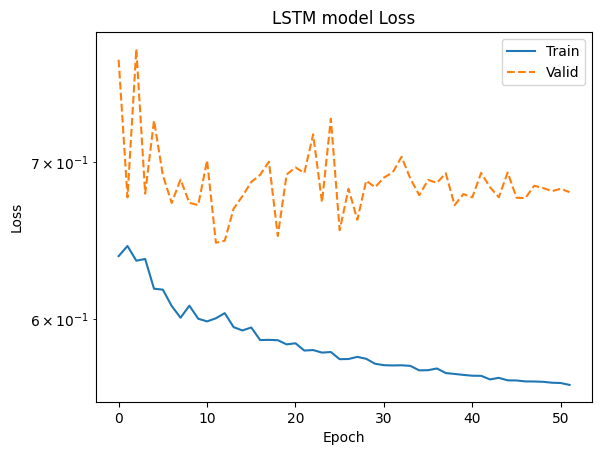

In [31]:
plot_loss(history)

In [32]:
results = lstm_model.evaluate(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    verbose=0
)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.6249


In [33]:
baseline_results = lstm_model.evaluate(
    valid_features,
    valid_labels,
    batch_size=BATCH_SIZE,
    verbose=0
)
for name, value in zip(lstm_model.metrics_names, baseline_results):
  print(f'{name} : {value}')

loss : 0.67622309923172
cross entropy : 0.67622309923172
Brier score : 0.23583145439624786
tp : 80.0
fp : 668.0
tn : 1426.0
fn : 124.0
accuracy : 0.6553524732589722
precision : 0.10695187002420425
recall : 0.3921568691730499
auc : 0.5454660058021545
prc : 0.11707597970962524


In [34]:
lstm_model.save_weights(checkpoints_path)

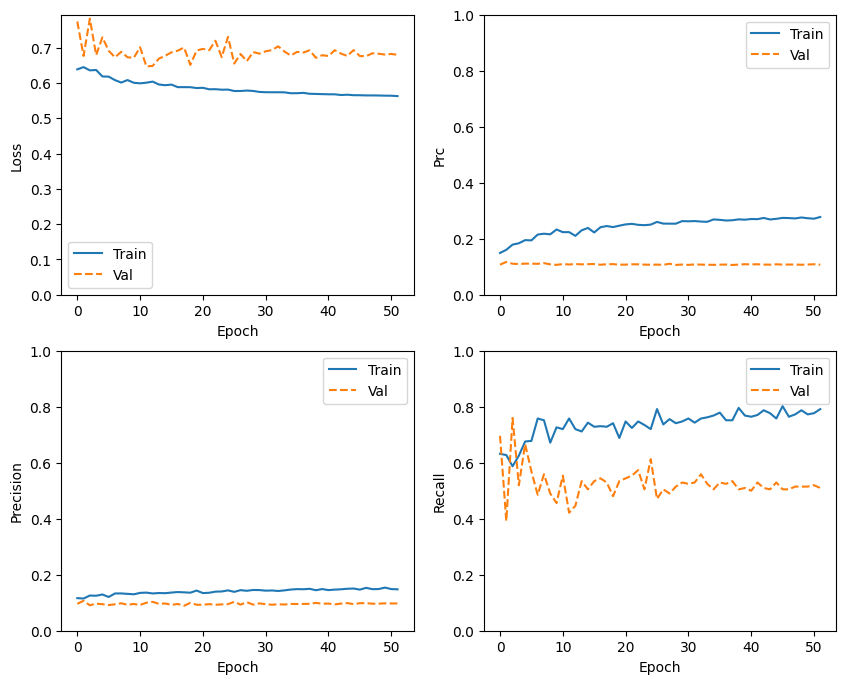

In [35]:
plot_metrics(history)

In [36]:
emb_model = get_ts_embeddings_model(lstm_model)
emb_lstm_train = get_ts_embeddings(X_train, seq_train, emb_model)
emb_lstm_valid = get_ts_embeddings(X_valid, seq_valid, emb_model)

72/72 [==============================] - 0s 2ms/step


In [37]:
emb_lstm_train.sample(2)

,ts_emb_0,ts_emb_1,ts_emb_2,ts_emb_3,ts_emb_4,ts_emb_5,ts_emb_6,ts_emb_7
customerid,,,,,,,,
2195,0.000029,-0.260309,2.459476e-05,0.000709,0.034961,-0.001727,0.000008,0.945660
512,-0.000013,-0.481707,4.780481e-07,0.000007,0.008777,-0.001213,0.000026,0.656746


In [38]:
X_train = pd.concat([X_train, emb_lstm_train], axis=1)
X_valid = pd.concat([X_valid, emb_lstm_valid], axis=1)

X_train.sample(2)

,age,annualincome,calldroprate,callfailurerate,callingnum,customerid,customersuspended,education,gender,homeowner,...,seq_total,seq_avg,ts_emb_0,ts_emb_1,ts_emb_2,ts_emb_3,ts_emb_4,ts_emb_5,ts_emb_6,ts_emb_7
customerid,,,,,,,,,,,,,,,,,,,,,
5306,30,167846,0.04,0.01,4251050289,5306,Yes,PhD or equivalent,Female,Yes,...,"[3793, 2214, 0]","[541, 738, 0]",0.007436,-0.00159,0.000006,0.000028,0.000410,-0.043171,0.002941,0.985537
5967,19,42908,0.06,0.00,4251073331,5967,Yes,PhD or equivalent,Female,No,...,"[3442, 2193, 0]","[860, 731, 0]",-0.000126,-0.50745,0.000126,-0.000042,0.012762,-0.206262,0.000356,0.855938


### 2.4. Категориальные переменные

In [39]:
categorical_variables = X_train.dtypes[X_train.dtypes=='object'].index.tolist()[:-2]

categorical_info = X_train[categorical_variables].nunique()
categorical_info

customersuspended       2
education               4
gender                  2
homeowner               2
maritalstatus           2
occupation              3
state                  50
usesinternetservice     2
usesvoiceservice        2
dtype: int64

#### 2.3.1. Ембеддинги

In [40]:
train = pd.concat([X_train, y_train], axis=1)
valid = pd.concat([X_valid, y_valid], axis=1)

In [41]:
feature = 'state'
train.groupby(feature)[TARGET_NAME].mean().sort_values()

state
DE    0.027273
VT    0.031250
NJ    0.037383
NE    0.043478
AL    0.050000
ME    0.053191
NV    0.056604
MD    0.058333
MN    0.060345
LA    0.062500
FL    0.066667
OR    0.070000
TN    0.071429
IN    0.072727
IL    0.072917
CT    0.075269
AR    0.077778
MT    0.081301
MS    0.081633
OK    0.082474
MO    0.082569
AK    0.083333
MI    0.085714
MA    0.086207
WI    0.086957
WY    0.086957
NH    0.087719
GA    0.088889
UT    0.090090
ID    0.090909
ND    0.095652
NM    0.096154
SD    0.097087
RI    0.098214
WV    0.102273
VA    0.104762
HI    0.106870
WA    0.107143
KS    0.110000
TX    0.111111
NC    0.112360
IA    0.113821
KY    0.115702
AZ    0.117117
PA    0.117117
CA    0.119658
CO    0.126050
OH    0.129630
NY    0.140351
SC    0.160714
Name: churn, dtype: float64

In [42]:
output_dim = 4
emb_train, lookup_and_embed = fit_transform_embeddings(train, feature, output_dim)
emb_valid = transform_embeddings(valid, feature, output_dim, lookup_and_embed)

train = pd.concat([train, emb_train], axis=1)
valid = pd.concat([valid, emb_valid], axis=1)

categorical_variables = [i for i in categorical_variables if i != feature]
train.sample(2)

,age,annualincome,calldroprate,callfailurerate,callingnum,customerid,customersuspended,education,gender,homeowner,...,ts_emb_3,ts_emb_4,ts_emb_5,ts_emb_6,ts_emb_7,churn,state_0,state_1,state_2,state_3
customerid,,,,,,,,,,,,,,,,,,,,,
1595,55,235838,0.01,0.00,4251092187,1595,Yes,Bachelor or equivalent,Female,Yes,...,0.000039,0.038792,0.031586,7.184990e-05,0.129182,0,-0.03762,-0.03362,-0.045718,-0.005864
6413,29,9124,0.04,0.03,4251065003,6413,Yes,Master or equivalent,Male,Yes,...,0.005884,-0.000059,0.185694,5.028116e-07,0.710313,1,-0.03762,-0.03362,-0.045718,-0.005864


#### 2.3.2. One-hot encoding

In [43]:
for feature in categorical_variables:
  print(f'{df.groupby(feature)[TARGET_NAME].mean().sort_values(ascending=False)}\n')

customersuspended
No     0.103659
Yes    0.088337
Name: churn, dtype: float64

education
PhD or equivalent         0.100257
Bachelor or equivalent    0.092863
High School or below      0.089493
Master or equivalent      0.073593
Name: churn, dtype: float64

gender
Female    0.093774
Male      0.083266
Name: churn, dtype: float64

homeowner
No     0.094227
Yes    0.087303
Name: churn, dtype: float64

maritalstatus
Single     0.094742
Married    0.082236
Name: churn, dtype: float64

occupation
Non-technology Related Job    0.098610
Others                        0.085294
Technology Related Job        0.083188
Name: churn, dtype: float64

usesinternetservice
Yes    0.104575
No     0.088003
Name: churn, dtype: float64

usesvoiceservice
Yes    0.089209
No     0.088611
Name: churn, dtype: float64



In [44]:
for feature in ['education', 'occupation']:
  oh_train, str_lookup_layer = fit_transform_one_hot_encoding(train, feature)
  oh_valid = transform_one_hot_encoding(valid, feature, str_lookup_layer)

  train = pd.concat([train, oh_train], axis=1)
  valid = pd.concat([valid, oh_valid], axis=1)

train.sample(2)

,age,annualincome,calldroprate,callfailurerate,callingnum,customerid,customersuspended,education,gender,homeowner,...,state_1,state_2,state_3,High School or below,Bachelor or equivalent,PhD or equivalent,Master or equivalent,Non-technology Related Job,Others,Technology Related Job
customerid,,,,,,,,,,,,,,,,,,,,,
3162,33,200745,0.00,0.01,4251050589,3162,Yes,Bachelor or equivalent,Male,Yes,...,-0.013398,-0.045258,0.005770,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1314,22,237698,0.03,0.01,4251067115,1314,Yes,High School or below,Female,No,...,0.041506,-0.042313,-0.026645,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [45]:
categorical_variables = [i for i in categorical_variables if not i in ['education', 'occupation']]

#### 2.3.3. Бинарные признаки

In [46]:
train = map_categorical_features(train)
valid = map_categorical_features(valid)

train[categorical_variables].sample(2)

,customersuspended,gender,homeowner,maritalstatus,usesinternetservice,usesvoiceservice
customerid,,,,,,
6788,1,1,0,1,0,0
4659,1,0,1,1,0,0


In [47]:
selected_categorical_features = categorical_variables + [
    'state_0',
    'state_1',
    'state_2',
    'state_3',
    'High School or below',
    'Bachelor or equivalent',
    'Master or equivalent',
    'PhD or equivalent',
    'Non-technology Related Job',
    'Technology Related Job',
    'Others',
]
selected_categorical_features

['customersuspended',
 'gender',
 'homeowner',
 'maritalstatus',
 'usesinternetservice',
 'usesvoiceservice',
 'state_0',
 'state_1',
 'state_2',
 'state_3',
 'High School or below',
 'Bachelor or equivalent',
 'Master or equivalent',
 'PhD or equivalent',
 'Non-technology Related Job',
 'Technology Related Job',
 'Others']

### 2.5. Численные переменные

In [48]:
numeric_variables = train.dtypes[
    (train.dtypes=='int64') | (train.dtypes=='float64')
].index.tolist()
train[numeric_variables].nunique()

age                                       68
annualincome                            5357
calldroprate                               8
callfailurerate                            4
callingnum                              5360
customerid                              5360
customersuspended                          2
gender                                     2
homeowner                                  2
maritalstatus                              2
monthlybilledamount                      120
numberofcomplaints                         4
numberofmonthunpaid                        8
numdayscontractequipmentplanexpiring     100
penaltytoswitch                          500
totalminsusedinlastmonth                 500
unpaidbalance                            250
usesinternetservice                        2
usesvoiceservice                           2
percentagecalloutsidenetwork             100
no_info_1                                  2
no_info_3                                  2
seq_total_

In [49]:
numeric_variables = [i for i in numeric_variables if not i in [TARGET_NAME]]

In [50]:
get_correlated_features(train, numeric_variables, threshold=0.6)

In [51]:
corr = train[[TARGET_NAME] + numeric_variables].corr()[[TARGET_NAME]]
ind = abs(corr).sort_values(by=TARGET_NAME, ascending=False).index
corr.loc[ind, :]

,churn
churn,1.000000
age,-0.148356
numberofcomplaints,0.051683
unpaidbalance,0.037784
seq_total_max,-0.020359
usesvoiceservice,0.020271
calldroprate,0.019154
gender,-0.018859
customersuspended,-0.018436
percentagecalloutsidenetwork,-0.017937


* Наибольшая корреляция с целевой переменной наблюдается у признака age.

#### A. Дискретные переменные

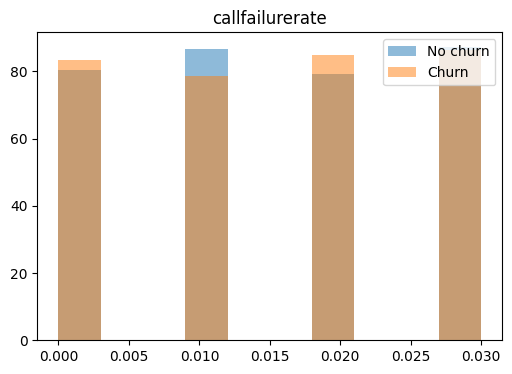

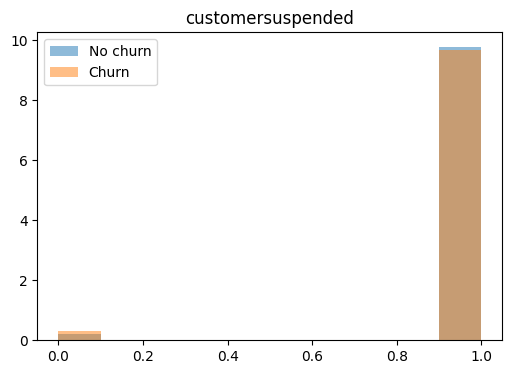

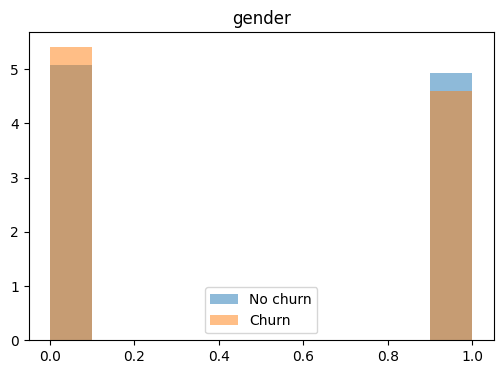

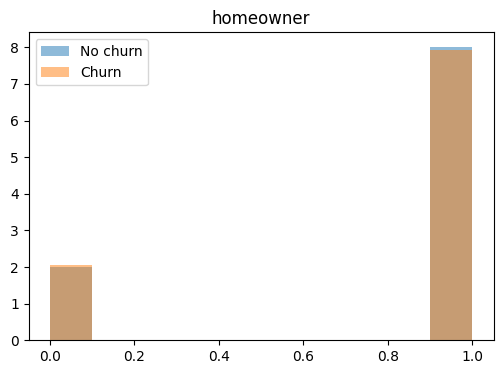

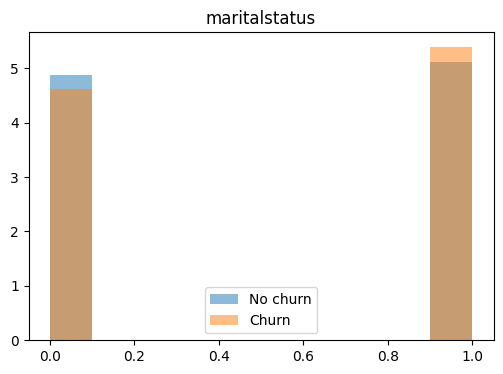

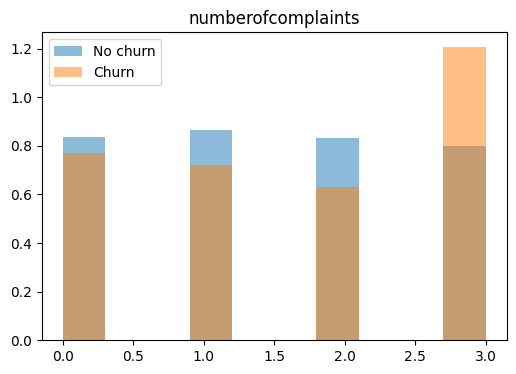

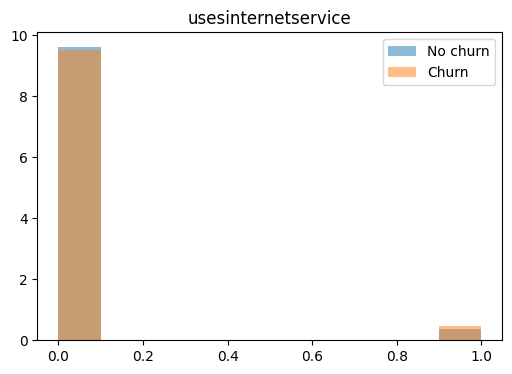

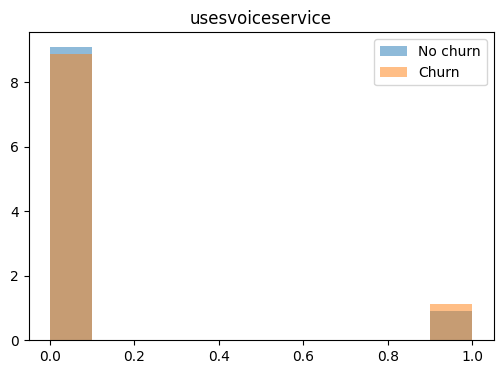

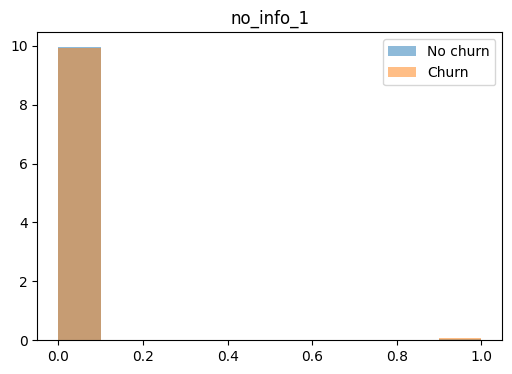

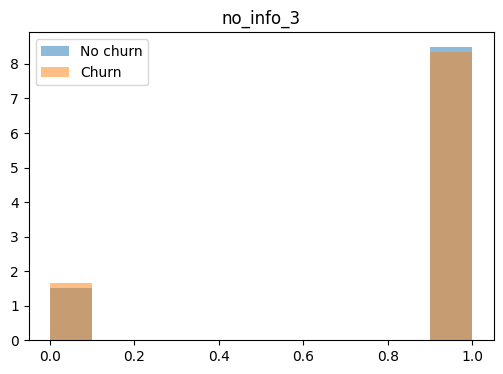

In [52]:
discrete = train[numeric_variables].nunique()
discrete_variables = discrete[discrete < 5].index.tolist()

for feature in discrete_variables:
  var_target_0 = train.loc[train[TARGET_NAME] == 0, feature]
  var_target_1 = train.loc[train[TARGET_NAME] == 1, feature]

  plt.figure(figsize=(6, 4))

  plt.hist(var_target_0, density=True, alpha=0.5, label='No churn')
  plt.hist(var_target_1, density=True, alpha=0.5, label='Churn')
  plt.title(feature)
  plt.legend();

In [53]:
for feature in discrete_variables:
  print(f'{train.groupby(feature)[TARGET_NAME].mean().sort_index()}\n')

callfailurerate
0.00    0.091750
0.01    0.081101
0.02    0.094531
0.03    0.087732
Name: churn, dtype: float64

customersuspended
0    0.122951
1    0.087820
Name: churn, dtype: float64

gender
0    0.093864
1    0.083143
Name: churn, dtype: float64

homeowner
0    0.091503
1    0.087899
Name: churn, dtype: float64

maritalstatus
0    0.084134
1    0.092855
Name: churn, dtype: float64

numberofcomplaints
0    0.082397
1    0.075128
2    0.068702
3    0.127976
Name: churn, dtype: float64

usesinternetservice
0    0.087784
1    0.109005
Name: churn, dtype: float64

usesvoiceservice
0    0.086778
1    0.106640
Name: churn, dtype: float64

no_info_1
0    0.088439
1    0.130435
Name: churn, dtype: float64

no_info_3
0    0.096695
1    0.087167
Name: churn, dtype: float64



In [54]:
selected_discrete = ['callfailurerate', 'numberofcomplaints']

In [55]:
selected_vars_Chi2_discrete = []
for feature in discrete_variables:
  churn = train.loc[train[TARGET_NAME]==1, feature].values
  no_churn = train.loc[train[TARGET_NAME]==0, feature].values

  df_bins = pd.DataFrame()
  df_bins['bin'] = train.loc[df[TARGET_NAME]==1, feature].value_counts().sort_index().index
  df_bins['no_churn_observed'] = train.loc[
      train[TARGET_NAME]==0, feature
  ].value_counts().sort_index().values
  df_bins['churn_observed'] = train.loc[
      train[TARGET_NAME]==1, feature
  ].value_counts().sort_index().values

  df_bins['churn_expected'] = df_bins['no_churn_observed'] / np.sum(df_bins['no_churn_observed']) * np.sum(df_bins['churn_observed'])
  stat, p_value = chisquare(df_bins['churn_observed'], df_bins['churn_expected'])

  if p_value < 0.05:
      selected_vars_Chi2_discrete.append(feature)
      print(f"{feature}\nChi-squared Test: statistic={stat:.4f}, p-value={p_value:.4f}\n")
      print(f'{df_bins}\n')

numberofcomplaints
Chi-squared Test: statistic=40.5057, p-value=0.0000

   bin  no_churn_observed  churn_observed  churn_expected
0    0               1225             110      119.114637
1    1               1268             103      123.295803
2    2               1220              90      118.628454
3    3               1172             172      113.961105



* В переменной numberofcomplaints наше p-значение ниже 5%, поэтому с достоверностью 95% отвергаем нулевую гипотезу об одинаковости двух распределений.

numberofcomplaints
Kolmogorov-Smirnov Test: statistic=0.1222, p-value=0.0000



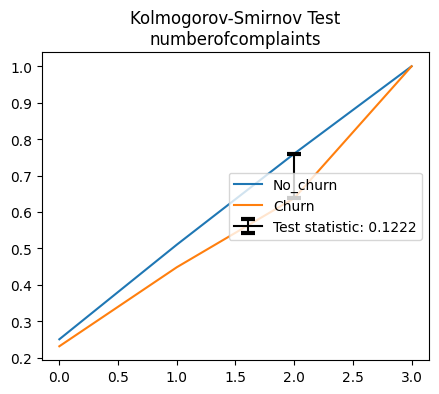

In [56]:
selected_vars_KS_discrete = []
for feature in discrete_variables:
  churn = train.loc[train[TARGET_NAME]==1, feature].values
  no_churn = train.loc[train[TARGET_NAME]==0, feature].values

  stat, p_value = kstest(churn, no_churn)
  if  p_value < 0.05:
    print(f"{feature}\nKolmogorov-Smirnov Test: statistic={stat:.4f}, p-value={p_value:.4f}\n")
    selected_vars_KS_discrete.append(feature)
    plot_ks_test(df, feature, churn, no_churn)

In [57]:
selected_vars_discrete = list(
    set(selected_discrete + selected_vars_KS_discrete + selected_vars_Chi2_discrete)
)
selected_vars_discrete

['callfailurerate', 'numberofcomplaints']

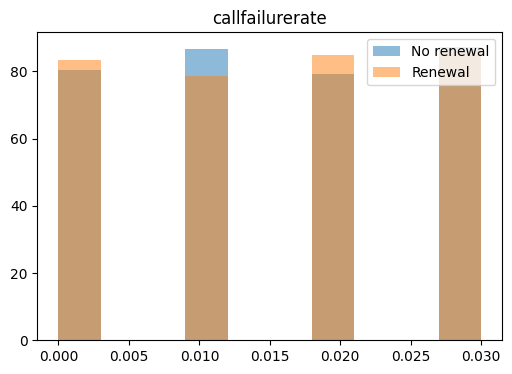

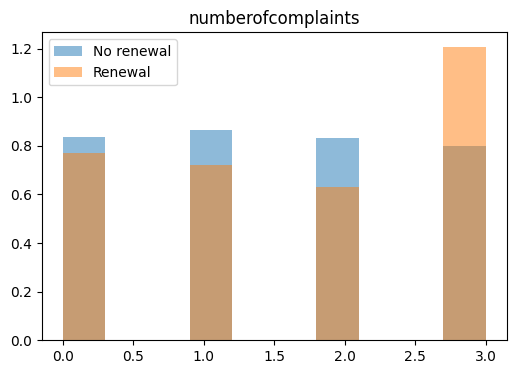

In [58]:
for feature in selected_vars_discrete:
  plt.figure(figsize=(6, 4))
  var_target_0 = train.loc[train[TARGET_NAME] == 0, feature]
  var_target_1 = train.loc[train[TARGET_NAME] == 1, feature]

  plt.hist(var_target_0, density=True, alpha=0.5, label='No renewal')
  plt.hist(var_target_1, density=True, alpha=0.5, label='Renewal')
  plt.title(feature)
  plt.legend();

#### B. Непрерывные переменные

In [59]:
continuous_variables = [i for i in numeric_variables if not i in discrete_variables]

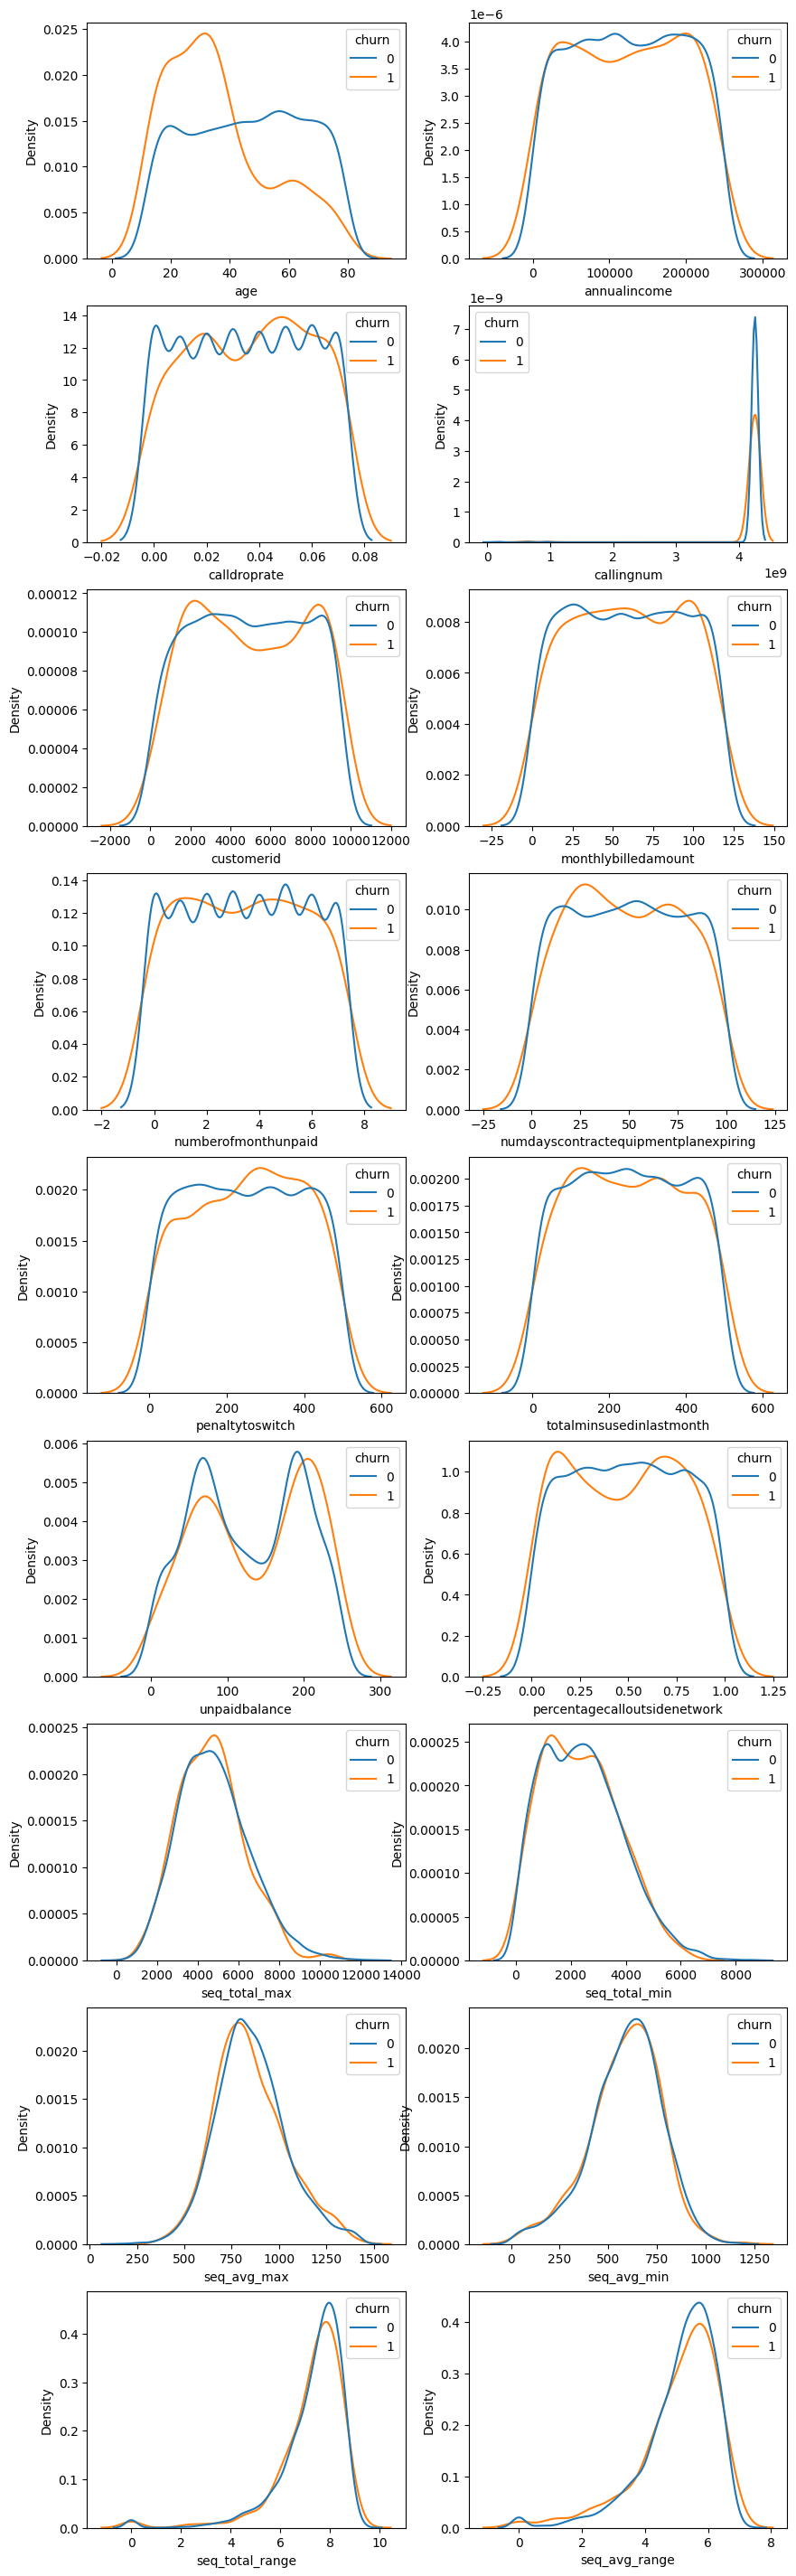

In [60]:
fig, axes = plt.subplots(9, 2, figsize=(10, 36))
for num, feature in enumerate(continuous_variables):
  sns.kdeplot(train, x=feature, hue=TARGET_NAME, ax=axes[num//2, num%2], common_norm=False)

##### Тест хи-квадрат

In [61]:
selected_vars_Chi2 = []
for feature in continuous_variables:
  if feature in ['calldroprate', 'numberofmonthunpaid',]:
    continue
  churn = train.loc[train[TARGET_NAME]==1, feature].values
  no_churn = train.loc[train[TARGET_NAME]==0, feature].values

  df_bins = pd.DataFrame()

  # Generate bins from control group
  _, bins = pd.qcut(no_churn, q=10, retbins=True)
  df_bins['bin'] = pd.cut(no_churn, bins=bins).value_counts().index

  # Apply bins to both groups
  df_bins['no_churn_observed'] = pd.cut(no_churn, bins=bins).value_counts().values
  df_bins['churn_observed'] = pd.cut(churn, bins=bins).value_counts().values

  # Compute expected frequency in the treatment group
  df_bins['churn_expected'] = df_bins['no_churn_observed'] / np.sum(df_bins['no_churn_observed']) * np.sum(df_bins['churn_observed'])


  stat, p_value = chisquare(df_bins['churn_observed'], df_bins['churn_expected'])

  if p_value < 0.05:
    selected_vars_Chi2.append(feature)
    print(f"{feature}\nChi-squared Test: statistic={stat:.4f}, p-value={p_value:.4f}\n")
    print(f'{df_bins}\n')

age
Chi-squared Test: statistic=167.5954, p-value=0.0000

            bin  no_churn_observed  churn_observed  churn_expected
0  (12.0, 18.0]                435              68       41.424274
1  (18.0, 25.0]                484              69       46.090456
2  (25.0, 33.0]                520              96       49.518672
3  (33.0, 40.0]                488              83       46.471369
4  (40.0, 47.0]                525              28       49.994813
5  (47.0, 53.0]                426              24       40.567220
6  (53.0, 59.0]                479              17       45.614315
7  (59.0, 66.0]                510              33       48.566390
8  (66.0, 73.0]                514              24       48.947303
9  (73.0, 79.0]                439              17       41.805187

unpaidbalance
Chi-squared Test: statistic=27.2520, p-value=0.0013

              bin  no_churn_observed  churn_observed  churn_expected
0     (0.0, 33.0]                493              40       47.964286

* В переменных age, unpaidbalance и percentagecalloutsidenetwork, seq_avg_max наше p-значение ниже 5%, поэтому с достоверностью 95% отвергаем нулевую гипотезу об одинаковости двух распределений.

##### Критерий Колмогорова — Смирнова

age
Kolmogorov-Smirnov Test: statistic=0.2939, p-value=0.0000

unpaidbalance
Kolmogorov-Smirnov Test: statistic=0.1079, p-value=0.0000



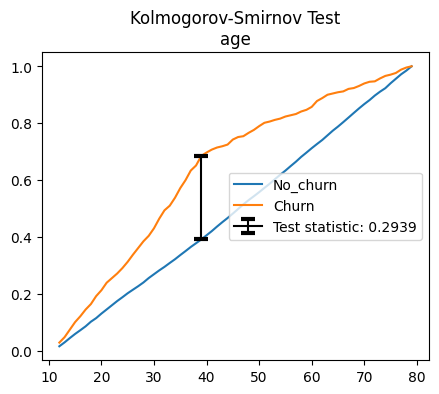

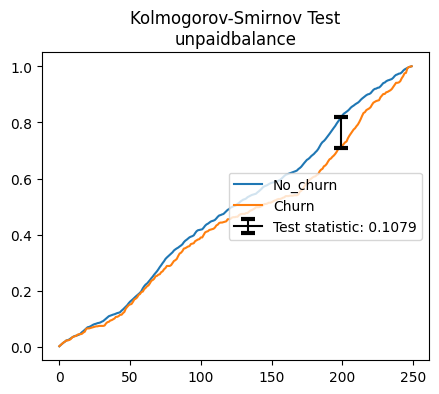

In [62]:
selected_vars_KS = []
for feature in continuous_variables:
  churn = df.loc[df[TARGET_NAME]==1, feature].values
  no_churn = df.loc[df[TARGET_NAME]==0, feature].values

  stat, p_value = kstest(churn, no_churn)
  if  p_value < 0.05:
    print(f"{feature}\nKolmogorov-Smirnov Test: statistic={stat:.4f}, p-value={p_value:.4f}\n")
    selected_vars_KS.append(feature)
    plot_ks_test(df, feature, churn, no_churn)

* В переменных age и unpaidbalance наше p-значение ниже 5%, поэтому с достоверностью 95% отвергаем нулевую гипотезу об одинаковости двух распределений.

In [63]:
selected_vars_continuous = [
    i for i in numeric_variables if i in set(selected_vars_Chi2) & set(selected_vars_KS)
]
selected_vars_continuous

['age', 'unpaidbalance']

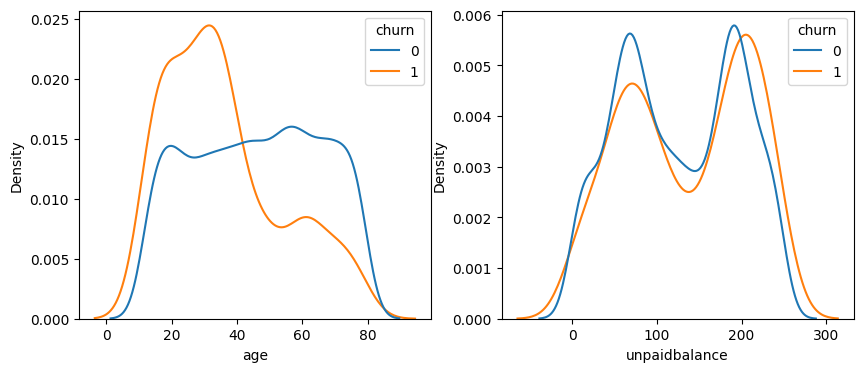

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for num, feature in enumerate(selected_vars_continuous):
  sns.kdeplot(
      train, x=feature, hue=TARGET_NAME, ax=axes[num%2], common_norm=False
  )

In [65]:
selected_numeric_features = selected_vars_discrete + selected_vars_continuous
selected_numeric_features

['callfailurerate', 'numberofcomplaints', 'age', 'unpaidbalance']

In [66]:
scaler_num = StandardScaler()

train[selected_numeric_features] = scaler_num.fit_transform(train[selected_numeric_features])
valid[selected_numeric_features] = scaler_num.transform(valid[selected_numeric_features])

In [67]:
selected_features = selected_numeric_features + categorical_variables
selected_features

['callfailurerate',
 'numberofcomplaints',
 'age',
 'unpaidbalance',
 'customersuspended',
 'gender',
 'homeowner',
 'maritalstatus',
 'usesinternetservice',
 'usesvoiceservice']

## 3. Отбор признаков c помощью Random Forest

In [68]:
cols = train.columns.tolist()
drop_list = [
    ID, TARGET_NAME, 'seq_total', 'seq_avg','education', 'occupation', 'state'
]
features_rf = [i for i in train.columns.tolist() if not i in drop_list]

### 3.1. Recursive feature elimination

In [69]:
rf = RandomForestClassifier(
    max_depth=10, random_state=25, class_weight = "balanced"
)
selector = RFE(rf, n_features_to_select=1, step=1)
selector = selector.fit(valid[features_rf].values, valid[TARGET_NAME])

impotances_RFE = pd.DataFrame(
    selector.ranking_,
    index=features_rf,
    columns=['impotances']
).sort_values(by='impotances')

impotances_RFE

,impotances
unpaidbalance,1
age,2
ts_emb_5,3
ts_emb_7,4
seq_avg_range,5
annualincome,6
seq_total_min,7
ts_emb_2,8
totalminsusedinlastmonth,9
callingnum,10


### 3.2. Random Forest feature importances

In [70]:
features_rf = impotances_RFE.index.tolist()[:-10]

rf = RandomForestClassifier(
    max_depth=10, random_state=25, class_weight = "balanced"
)
rf.fit(train[features_rf].values, train[TARGET_NAME])
y_pred_rf = rf.predict_proba(valid[features_rf].values)[:, 1]

roc_auc_score(y_valid, y_pred_rf)

0.7050653594771242

In [71]:
importances = pd.DataFrame(
    rf.feature_importances_,
    index=features_rf,
    columns=['importances']
).sort_values(by='importances', ascending=False)
importances

,importances
age,0.161560
unpaidbalance,0.069184
numberofcomplaints,0.063799
ts_emb_7,0.053385
ts_emb_5,0.051771
ts_emb_4,0.040866
ts_emb_0,0.037075
ts_emb_1,0.029409
ts_emb_3,0.028403
state_3,0.027976


In [72]:
set(selected_features) & set(importances.index)

{'age',
 'callfailurerate',
 'gender',
 'maritalstatus',
 'numberofcomplaints',
 'unpaidbalance',
 'usesvoiceservice'}

In [73]:
set(selected_features) - set(importances.index)

{'customersuspended', 'homeowner', 'usesinternetservice'}

In [74]:
set(importances.index) - set(selected_features)

{'Non-technology Related Job',
 'Others',
 'annualincome',
 'calldroprate',
 'callingnum',
 'monthlybilledamount',
 'numberofmonthunpaid',
 'numdayscontractequipmentplanexpiring',
 'penaltytoswitch',
 'percentagecalloutsidenetwork',
 'seq_avg_max',
 'seq_avg_min',
 'seq_avg_range',
 'seq_total_max',
 'seq_total_min',
 'seq_total_range',
 'state_0',
 'state_1',
 'state_2',
 'state_3',
 'totalminsusedinlastmonth',
 'ts_emb_0',
 'ts_emb_1',
 'ts_emb_2',
 'ts_emb_3',
 'ts_emb_4',
 'ts_emb_5',
 'ts_emb_6',
 'ts_emb_7'}

### 3.3. Комментарии

* Признаки age, numberofcomplaints и unpaidbalance ожидаемо отобрались и статистическим методами, и деревянными моделями.

* Согласно отбору RFE и Random Forest feature importances, эмбеддинги признаков, изменяющихся в времени - totalcallduration и avgcallduration и их производные также получили достаточно высокий рейтинг. Это послужило мотивацией для использования блока LSTM в нейросетевой модели.

* Ембеддинги state оказались в середине рейтинга RFE и не отобрались Random Forest, но у них есть потенциал в сочетании с временными ембеддингами: средний процент оттока существенно отличается по штатам от 2.7% (DE) до 16.1% (SC)

* Признак education имеет смысл использовать через one-hot encoding: самая большая разница в проценте оттока мажду PhD (10%) и Master (7.3%), в то время как High School (8.9%) и Bachelor (9.2%) неожиданно находятся между ними.

* Из дискретных признаков определенный потенциал имеет callfailurerate: разница оттока между 0.01 (8.1%) и 0.02 (9.5%) может улучшить результаты нейросетевой модели. Он был отобран деревянными моделями.

* Бинарные признаки maritalstatus и usesvoiceservice были отобраны деревянными моделями. К ним были добавлены customersuspended, gender, homeowner и usesinternetservice, у которых есть потенциал для улучшения результата нейросети - значиамая разница в проценте оттока между 0 и 1. Бинарные признаки, как правило, недооцениваются деревянными моделями.

* Непрерывные признаки annualincome, callingnum, monthlybilledamount, numdayscontractequipmentplanexpiring, penaltytoswitch, percentagecalloutsidenetwork, totalminsusedinlastmonth не прошли отбор с помощью критерия Колмогорова — Смирнова и не выглядят достаточно привлекательными, хотя и отобрались деревянными моделями.

* Baseline AUC для модели оттока составил 0.7051.


## 4. GLM + Random Forest

Бустинг из General Linear Model (GLM) и Random Forest может улучшить метрики у повысить интерпретируемость модели.


### 4.1. GLM

#### 4.1.1. Отбор признаков

In [75]:
cols = selected_features + [
    f'state_{i}' for i in range(4)] + [f'ts_emb_{i}' for i in range(8)
]
df_aic = pd.DataFrame()
df_auc = pd.DataFrame()
results = train[[TARGET_NAME]]
selected_models = []

In [76]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits)
X = train[cols]
y = train[TARGET_NAME]
ind = train.index
selected = pd.DataFrame(index=cols)
for fold, (idx_train, idx_test) in enumerate(cv.split(X, y)):
  idx_train, idx_test = ind[idx_train], ind[idx_test]
  model = sm.GLM(
      y[idx_train], X.loc[idx_train], family=sm.genmod.families.Binomial()
  ).fit(method='ncg')
  selected.loc[:, f'{fold}'] = np.where(model.pvalues < 0.05, 1, 0)
selected.loc['intercept', :] = 1

In [77]:
features_GLM = selected[selected.mean(axis=1) == 1].index.tolist()[:-1]
features_GLM

['numberofcomplaints',
 'age',
 'unpaidbalance',
 'customersuspended',
 'gender',
 'homeowner',
 'ts_emb_0',
 'ts_emb_2',
 'ts_emb_4',
 'ts_emb_5',
 'ts_emb_6',
 'ts_emb_7']

* GLM не отобрала ембеддинги признака state, но оставила почти все ембеддинги временных признаков. Это повышает мотивацию в пользу применения модели LSTM.

#### 4.1.2. Кросс-валидация

In [78]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits)
X = train[features_GLM]
aic_glm = []
models_glm = []
aucs_glm = []
for fold, (idx_train, idx_test) in enumerate(cv.split(X, y)):
  idx_train, idx_test = ind[idx_train], ind[idx_test]
  model = sm.GLM(
      y[idx_train], X.loc[idx_train], family=sm.genmod.families.Binomial()
  ).fit(method='ncg')
  models_glm.append(model)
  aic_glm.append(model.aic)
  print(models_glm[fold].summary2())
  y_pred = model.predict(X.loc[idx_test])
  results.loc[idx_test, 'GLM'] = y_pred
  aucs_glm.append(roc_auc_score(y[idx_test], y_pred))

df_aic['GLM'] = aic_glm
df_auc['GLM'] = aucs_glm

auc_mean = np.array(aucs_glm).mean()
auc_std = np.array(aucs_glm).std()
print(f'\nauc: {round(auc_mean, 4)} +/- {round(auc_std, 4)}')

                 Results: Generalized linear model
Model:               GLM               Method:          IRLS       
Link Function:       Logit             AIC:             2767.0062  
Dependent Variable:  churn             BIC:             -38069.2921
Date:                2023-10-13 20:32  Log-Likelihood:  -1371.5    
No. Observations:    4824              LL-Null:         -1445.1    
Df Model:            11                Deviance:        2743.0     
Df Residuals:        4812              Pearson chi2:    4.58e+03   
Converged:           1.0000            Scale:           1.0000     
-------------------------------------------------------------------
                    Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------
numberofcomplaints  0.1641   0.0514   3.1936 0.0014  0.0634  0.2649
age                -0.5375   0.0545  -9.8550 0.0000 -0.6445 -0.4306
unpaidbalance       0.1235   0.0511   2.4170 0.0156  0.0233  0.22

#### 4.1.3. Area Under the Curve (AUC)

In [79]:
df_auc.round(4)

,GLM
0,0.6979
1,0.7328
2,0.7223
3,0.7126
4,0.6714
5,0.6603
6,0.6425
7,0.7019
8,0.7293
9,0.7678


In [80]:
df_auc.max()

GLM    0.767802
dtype: float64

#### 4.2.4. Akaike Information Criterion (AIC)

In [81]:
df_aic.round(1)

,GLM
0,2767.0
1,2776.7
2,2769.6
3,2762.9
4,2763.9
5,2751.6
6,2743.3
7,2768.8
8,2766.4
9,2778.5


#### 4.1.5. Deviance residuals

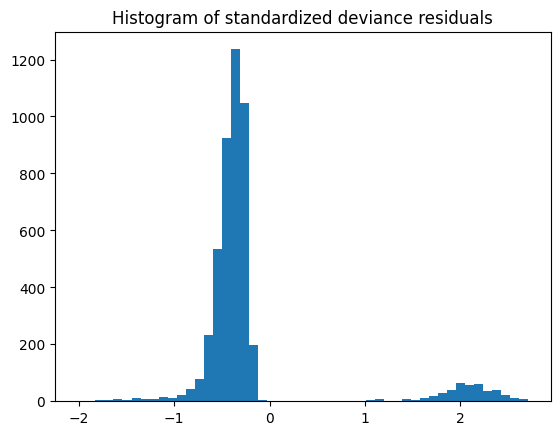

In [82]:
plt.hist(models_glm[np.argmax(aucs_glm)].resid_deviance, bins=50)
plt.title('Histogram of standardized deviance residuals');

В обучающей выборке одна группа deviance residuals наиболее часто встречается около -0.33, а другая - около 2.1. Распределение deviance residuals отклоняется от норамального. Confidence-интервалы предсказаний вероятно не точны.

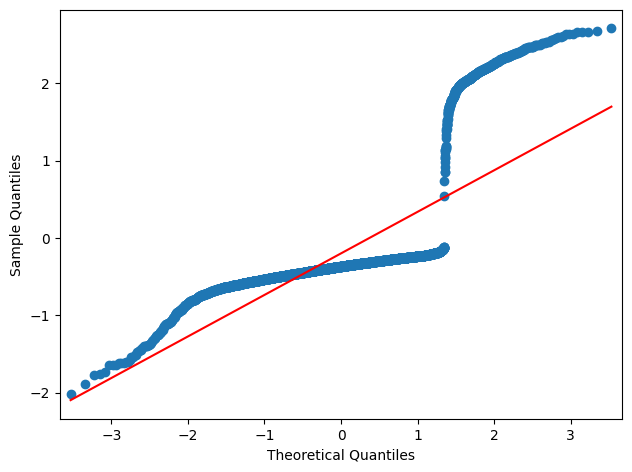

In [83]:
fig = sm.graphics.qqplot(models_glm[np.argmax(aucs_glm)].resid_deviance, line='r')
fig.tight_layout(pad=1.0)

* QQ-plot deviance residuals также говорит об отклонении от нормального распределения.

#### 4.1.6. Influence
Influence основана на одношаговой аппроксимации результатов удаления одного наблюдения. Одношаговые приближения обычно точны для небольших изменений, но недооценивают величину больших изменений.

Хотя большие изменения недооцениваются, influence все же ясно показывает влияние значимых наблюдений.

In [84]:
infl = models_glm[9].get_influence(observed=False)
summ_df = infl.summary_frame()
summ_df.sort_values("cooks_d", ascending=False).head(10)

,dfb_numberofcomplaints,dfb_age,dfb_unpaidbalance,dfb_customersuspended,dfb_gender,dfb_homeowner,dfb_ts_emb_0,dfb_ts_emb_2,dfb_ts_emb_4,dfb_ts_emb_5,dfb_ts_emb_6,dfb_ts_emb_7,cooks_d,standard_resid,hat_diag,dffits_internal
customerid,,,,,,,,,,,,,,,,
1462,-0.049816,0.004630,0.023143,-0.040537,-0.042112,-0.002502,0.024855,0.001332,0.001057,0.007680,0.412510,0.047907,0.015307,1.501769,0.075313,0.428587
1126,0.013736,-0.031359,0.017092,-0.025298,0.027923,0.001370,0.012997,0.002690,0.010738,0.007662,0.361231,-0.003900,0.011824,1.076846,0.109019,0.376678
3936,0.069100,0.096547,0.065679,0.094498,0.054157,-0.063062,0.279936,-0.063193,0.023166,-0.118203,0.015853,-0.064853,0.010041,3.181109,0.011767,0.347119
1622,0.005706,0.065287,0.036363,0.025564,0.054528,0.029766,0.065042,-0.175963,-0.261758,0.045386,-0.015744,-0.048221,0.009438,1.775517,0.034680,0.336535
5374,-0.050239,0.013277,-0.022047,-0.021377,0.029582,0.066121,-0.168844,0.127633,0.218067,-0.041690,0.004144,-0.016992,0.008563,-1.672592,0.035431,-0.320565
1666,-0.065026,0.073550,0.033302,-0.026523,0.042179,-0.093789,0.015802,-0.010457,-0.003339,0.056232,0.262733,0.081751,0.008531,2.458120,0.016659,0.319948
1951,0.037540,0.033907,-0.035304,0.013980,0.043886,-0.060410,-0.004413,-0.147176,-0.295563,-0.030584,-0.000697,0.027615,0.008338,1.429602,0.046670,0.316309
1974,0.020003,0.045955,0.044349,-0.072131,0.031687,-0.006074,0.226554,0.090297,0.099562,0.051360,0.005792,0.070185,0.008173,2.568520,0.014649,0.313178
6815,0.015480,-0.037691,-0.010010,-0.026864,0.048376,0.019042,-0.115354,0.270376,0.140008,0.068008,-0.016337,-0.005077,0.007936,3.327816,0.008526,0.308593


__Cook's distance__

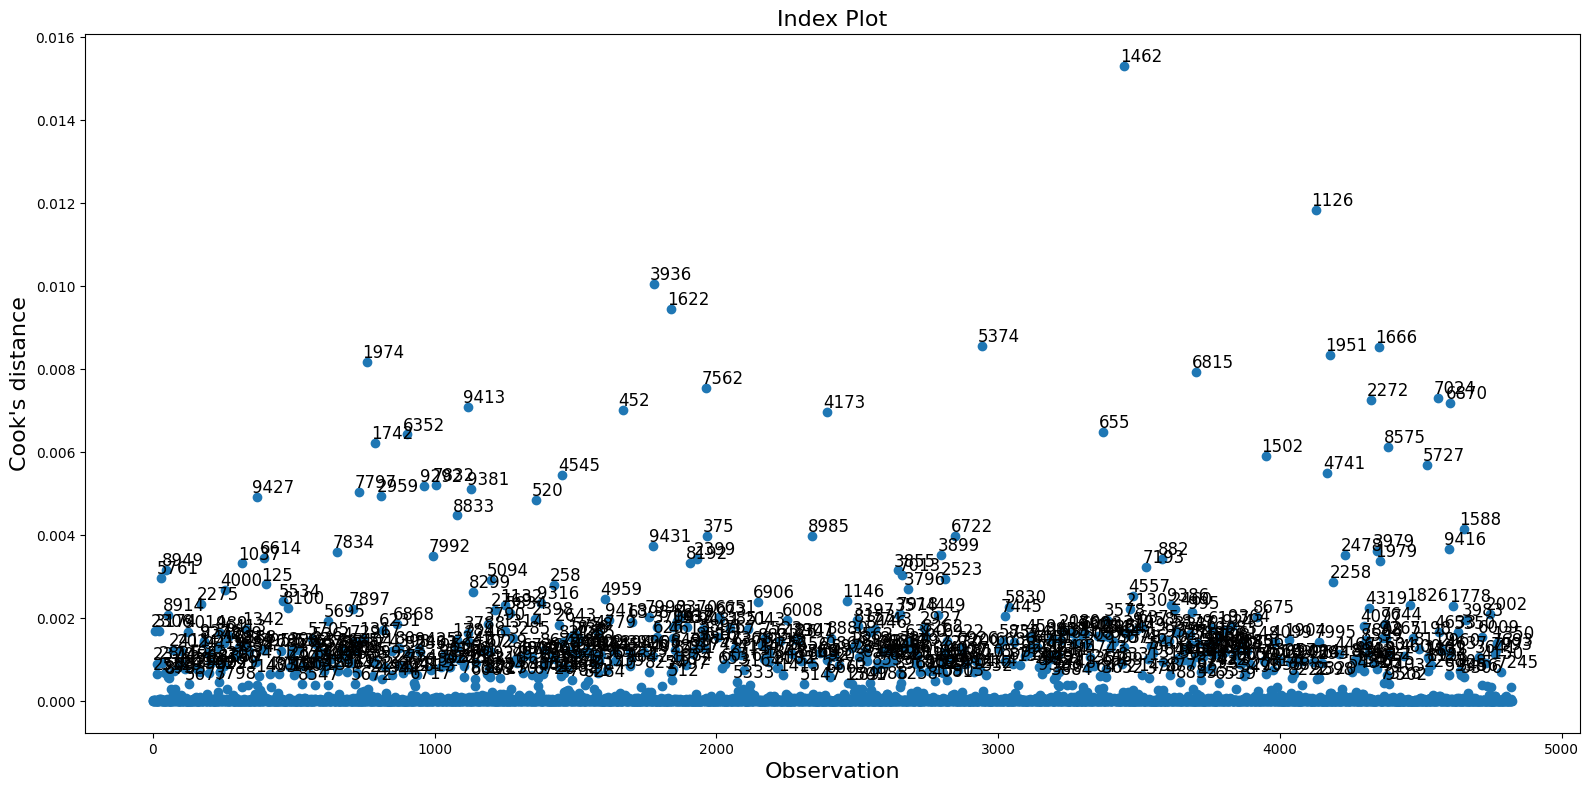

In [85]:
plt.rc("figure", figsize=(16, 8))

fig = infl.plot_index(
    y_var="cooks_d", threshold=2 * infl.cooks_distance[0].mean()
)
fig.tight_layout(pad=1.0)

In [86]:
ind = summ_df.sort_values("cooks_d", ascending=False)['cooks_d'].index[:10]
data.loc[ind, :]

,age,annualincome,calldroprate,callfailurerate,callingnum,customerid,customersuspended,education,gender,homeowner,...,totalminsusedinlastmonth,unpaidbalance,usesinternetservice,usesvoiceservice,percentagecalloutsidenetwork,totalcallduration,avgcallduration,churn,year,month
customerid,,,,,,,,,,,,,,,,,,,,,
1462,33,182301,0.00,0.01,4251071075,676,Yes,Bachelor or equivalent,Male,Yes,...,117,172,No,Yes,0.15,4679,935,0,2015,2
1126,59,46711,0.02,0.03,185409086,521,Yes,High School or below,Female,No,...,191,188,No,No,0.58,5986,748,0,2015,2
3936,28,230574,0.07,0.01,4251035514,1829,Yes,High School or below,Male,Yes,...,92,195,No,No,0.93,3089,772,0,2015,1
1622,45,212688,0.01,0.03,4251062161,750,Yes,High School or below,Male,No,...,29,46,No,No,0.84,1467,366,0,2015,1
5374,28,93124,0.05,0.00,4251068353,2491,Yes,Master or equivalent,Female,Yes,...,489,238,No,No,0.05,1421,1421,0,2015,1
1666,16,53952,0.02,0.01,4251088672,769,Yes,Bachelor or equivalent,Female,No,...,28,186,No,No,0.30,3835,958,0,2015,1
1951,77,243291,0.03,0.00,4251043680,901,Yes,High School or below,Female,No,...,249,184,No,No,0.32,1359,679,0,2015,1
1974,36,37938,0.04,0.02,4251074930,911,Yes,Bachelor or equivalent,Female,Yes,...,250,59,No,No,0.66,4680,585,0,2015,2
6815,18,202716,0.06,0.00,4251078140,3161,Yes,Bachelor or equivalent,Female,Yes,...,391,196,No,No,0.00,3023,604,0,2015,1


* Это 10 экземпляров обучающей выборки, наиболее влияющих на модель. Если их убрать, модель может существенно измениться.
* Вопрос, включать ли в модель экземпляры с самой большой Cook's distance нуждается в дальнейшей проработке. Возможно, линейная модель не может схватить все закономерности и требуется последовательная линейная комбинация с деревянной моделью.

__Residuals__

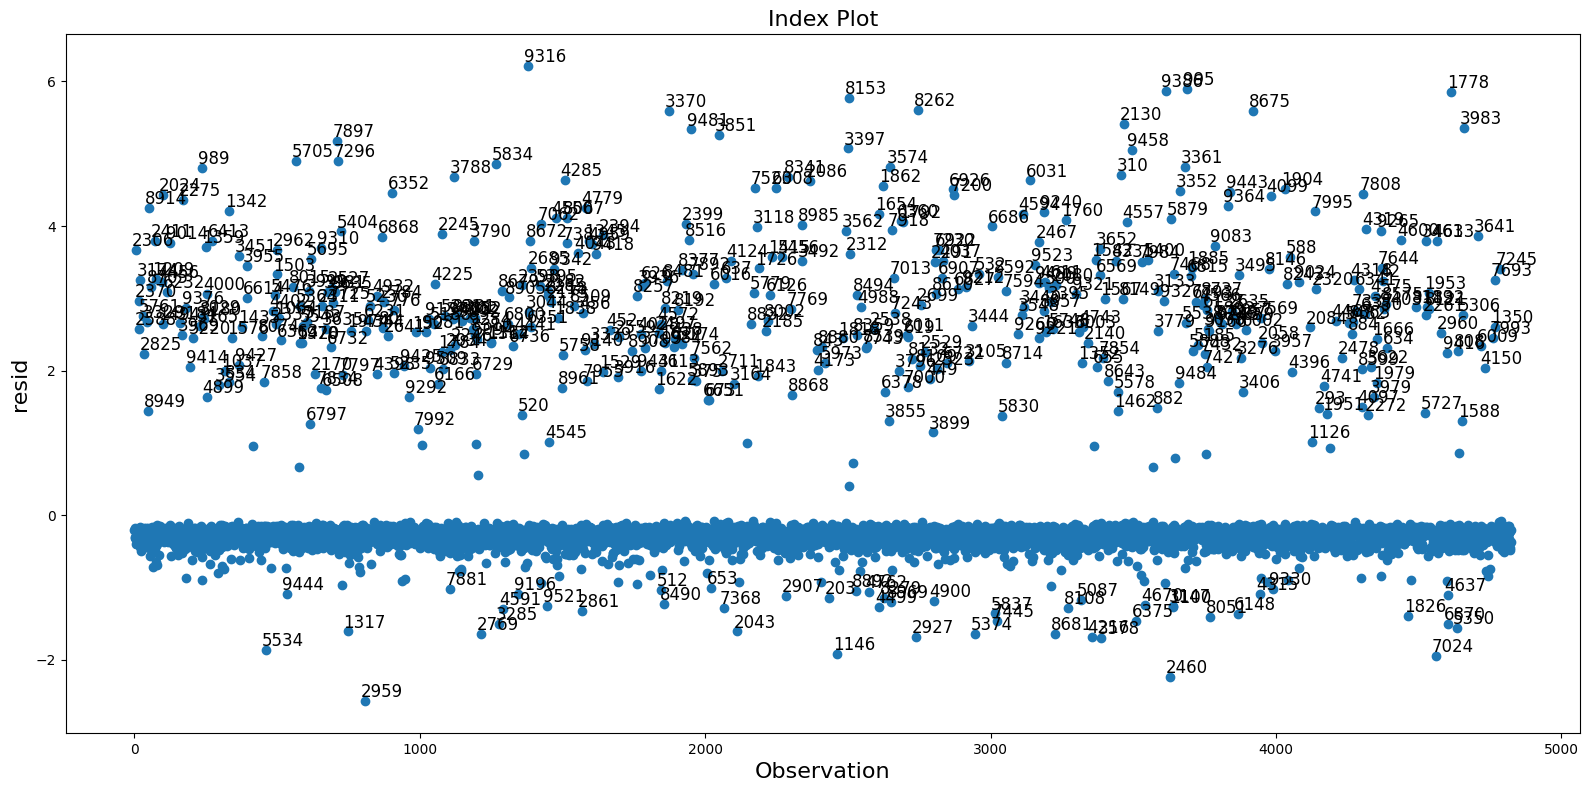

In [87]:
fig = infl.plot_index(y_var="resid", threshold=1)
fig.tight_layout(pad=1.0)

In [88]:
ind_res = summ_df.sort_values(
    "standard_resid", ascending=False
)['standard_resid'].index[:10]
data.loc[ind_res, :]

,age,annualincome,calldroprate,callfailurerate,callingnum,customerid,customersuspended,education,gender,homeowner,...,totalminsusedinlastmonth,unpaidbalance,usesinternetservice,usesvoiceservice,percentagecalloutsidenetwork,totalcallduration,avgcallduration,churn,year,month
customerid,,,,,,,,,,,,,,,,,,,,,
9316,18,235527,0.06,0.02,4251015868,4326,Yes,Master or equivalent,Male,Yes,...,469,9,No,No,0.91,3185,637,0,2015,2
995,31,28830,0.03,0.03,113860666,461,Yes,High School or below,Female,Yes,...,181,189,No,No,0.57,3854,642,0,2015,1
9386,55,32369,0.06,0.00,4251026388,4359,Yes,Master or equivalent,Male,Yes,...,275,98,No,No,0.72,3866,966,0,2015,2
1778,78,134145,0.03,0.02,4251100406,822,Yes,High School or below,Female,Yes,...,240,45,No,No,0.85,24,24,0,2015,3
8153,70,217864,0.00,0.00,4251010029,3789,Yes,High School or below,Male,Yes,...,491,104,No,No,0.61,3168,633,0,2015,1
8262,24,82168,0.06,0.03,4251096216,3837,Yes,High School or below,Female,Yes,...,298,104,No,No,0.62,5368,894,0,2015,1
3370,71,212798,0.03,0.03,4251081414,1566,Yes,High School or below,Male,Yes,...,349,212,No,No,0.33,4358,871,0,2015,1
8675,24,148317,0.07,0.00,4251079660,4031,Yes,High School or below,Male,Yes,...,228,227,No,No,0.33,2126,531,0,2015,1
2130,27,177254,0.06,0.01,4251097189,987,Yes,Bachelor or equivalent,Female,Yes,...,362,59,No,No,0.01,600,600,0,2015,2


In [89]:
summ_df[summ_df['standard_resid'] > 2].shape[0]

358

В обучающей выборке значительное количество экземпляров со standard_residual больше 2.

__Influence plot__

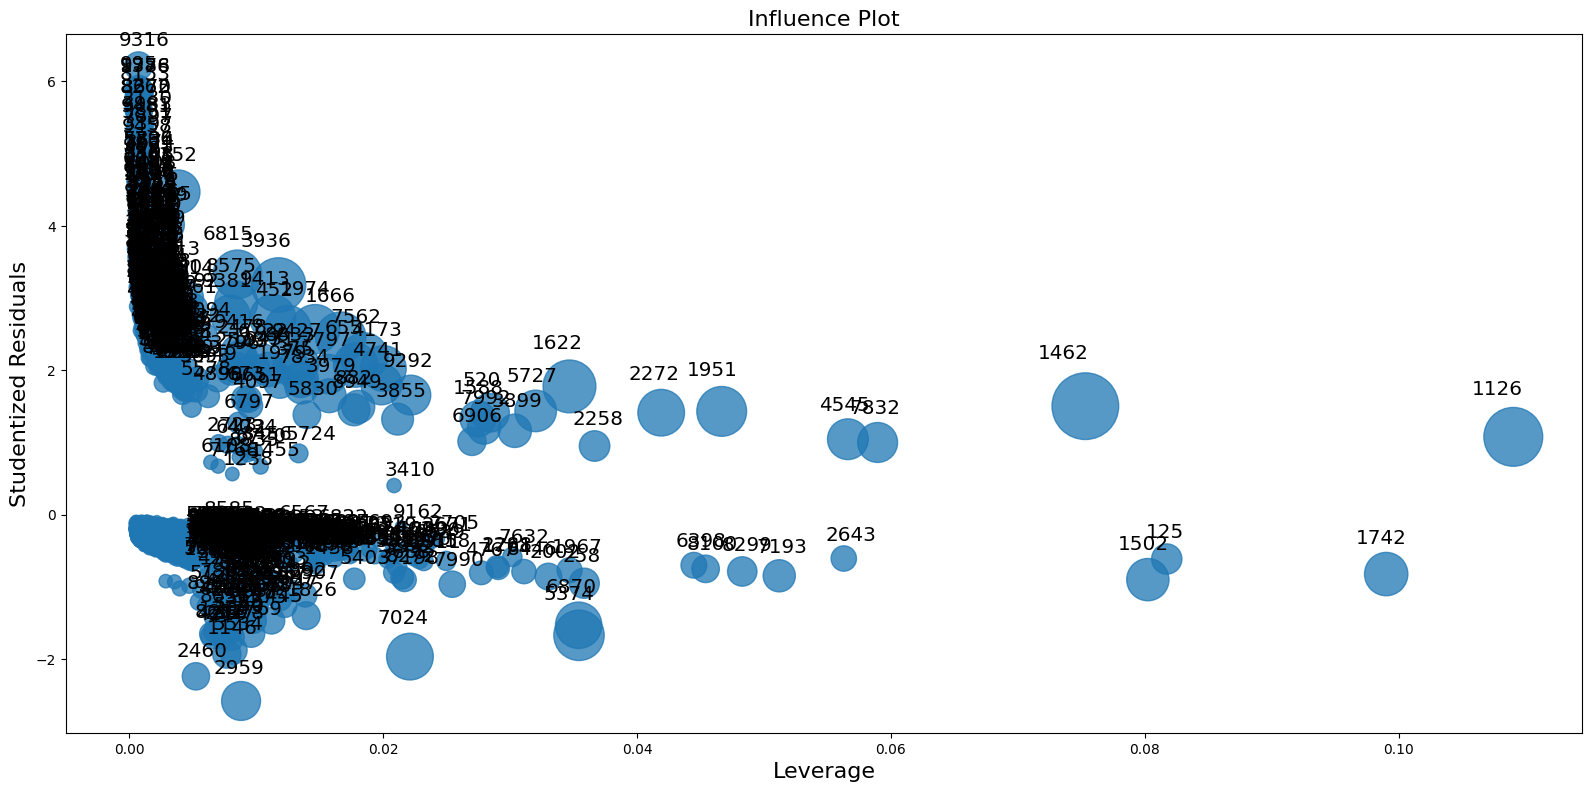

In [90]:
fig = infl.plot_influence()
fig.tight_layout(pad=1.0)

__dfbetas признаков модели__


[dfbetas](https://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.GLMInfluence.dfbetas.html) - масштабированное изменение оценок параметров.

Одношаговое изменение параметров масштабируется путем деления на стандартную ошибку оценки параметра

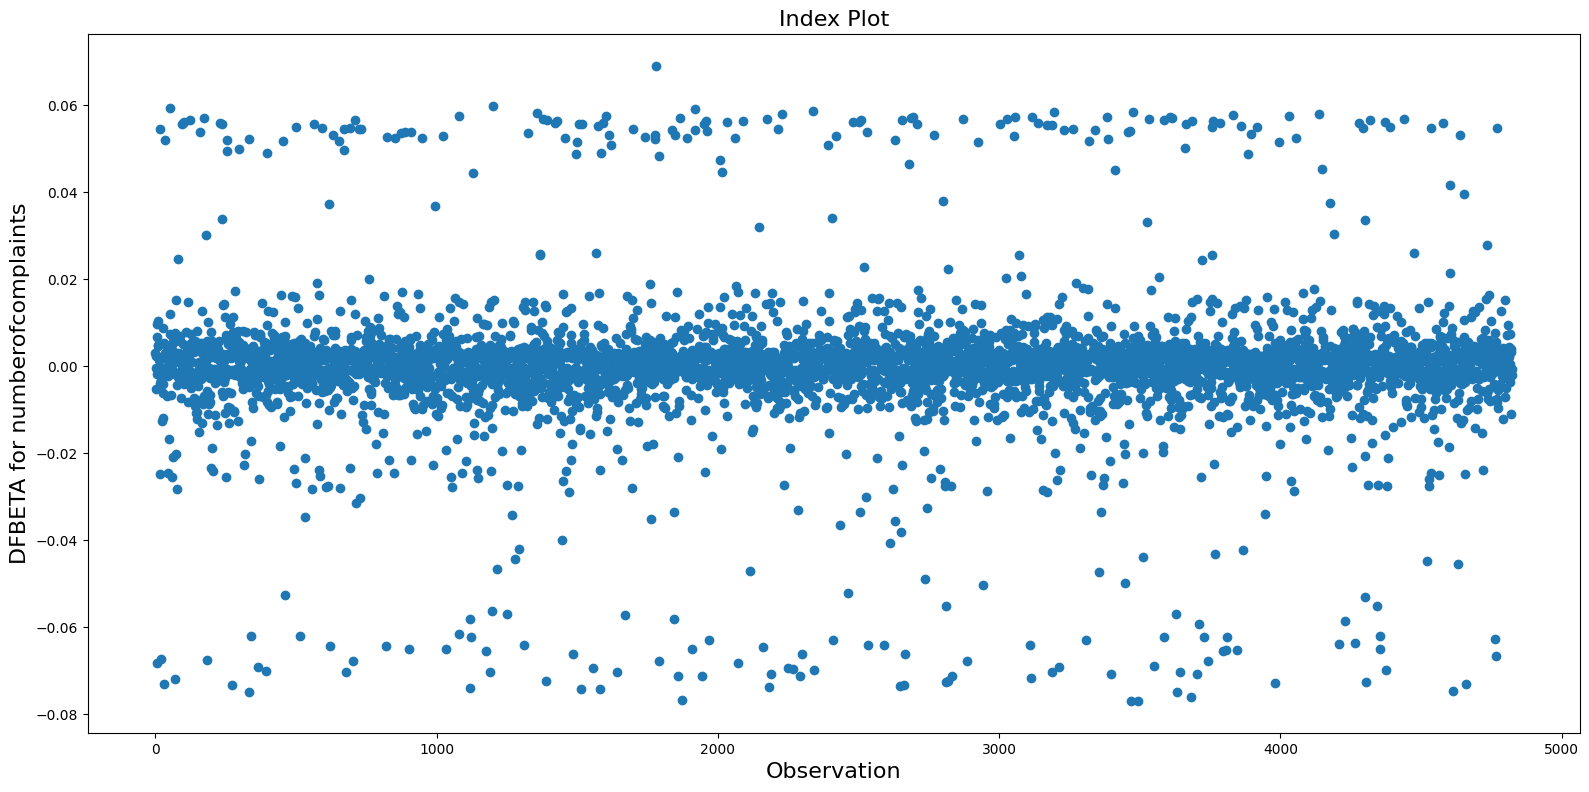

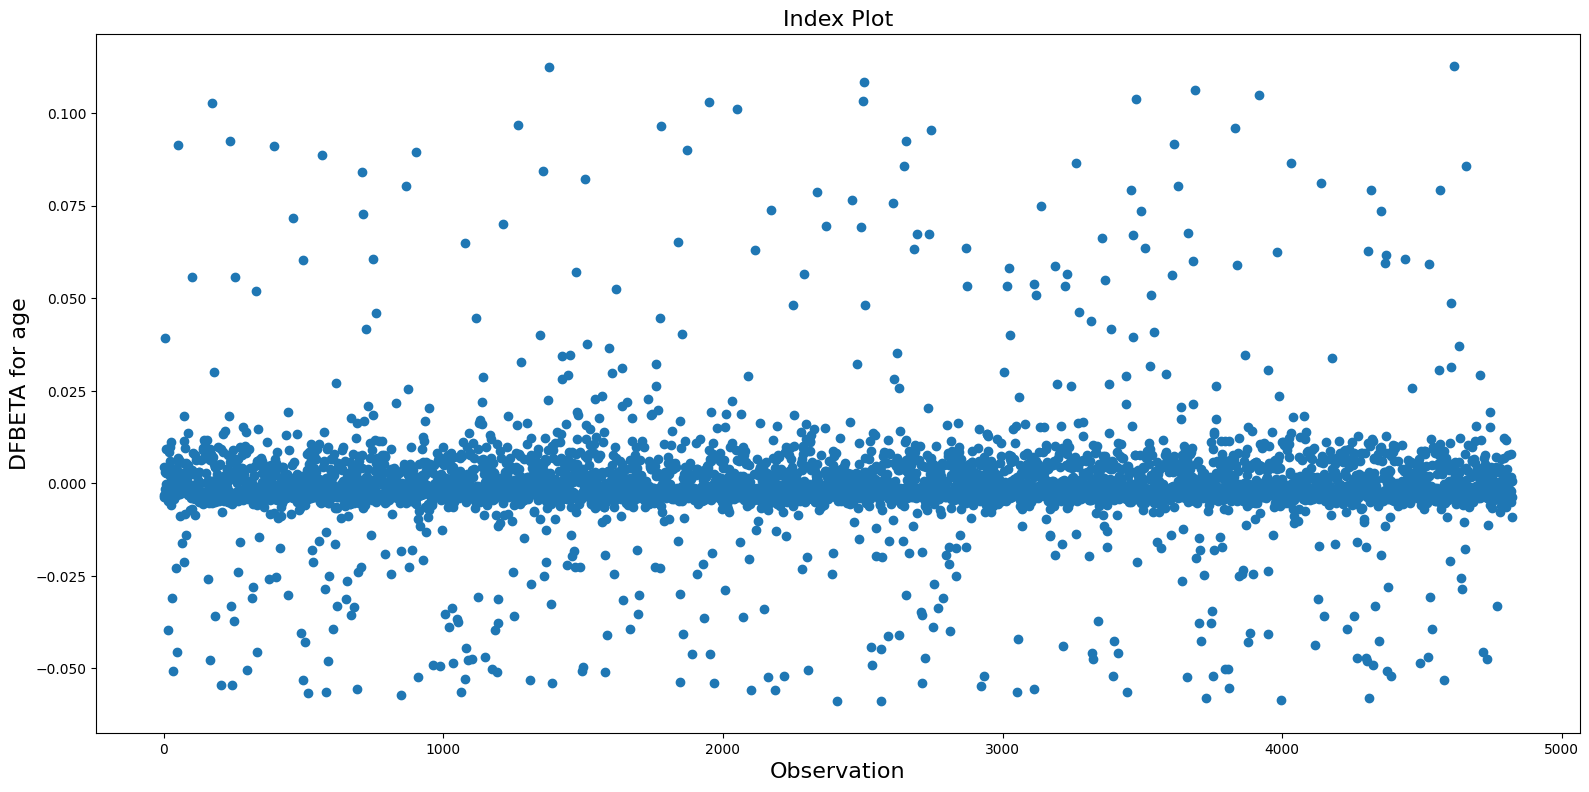

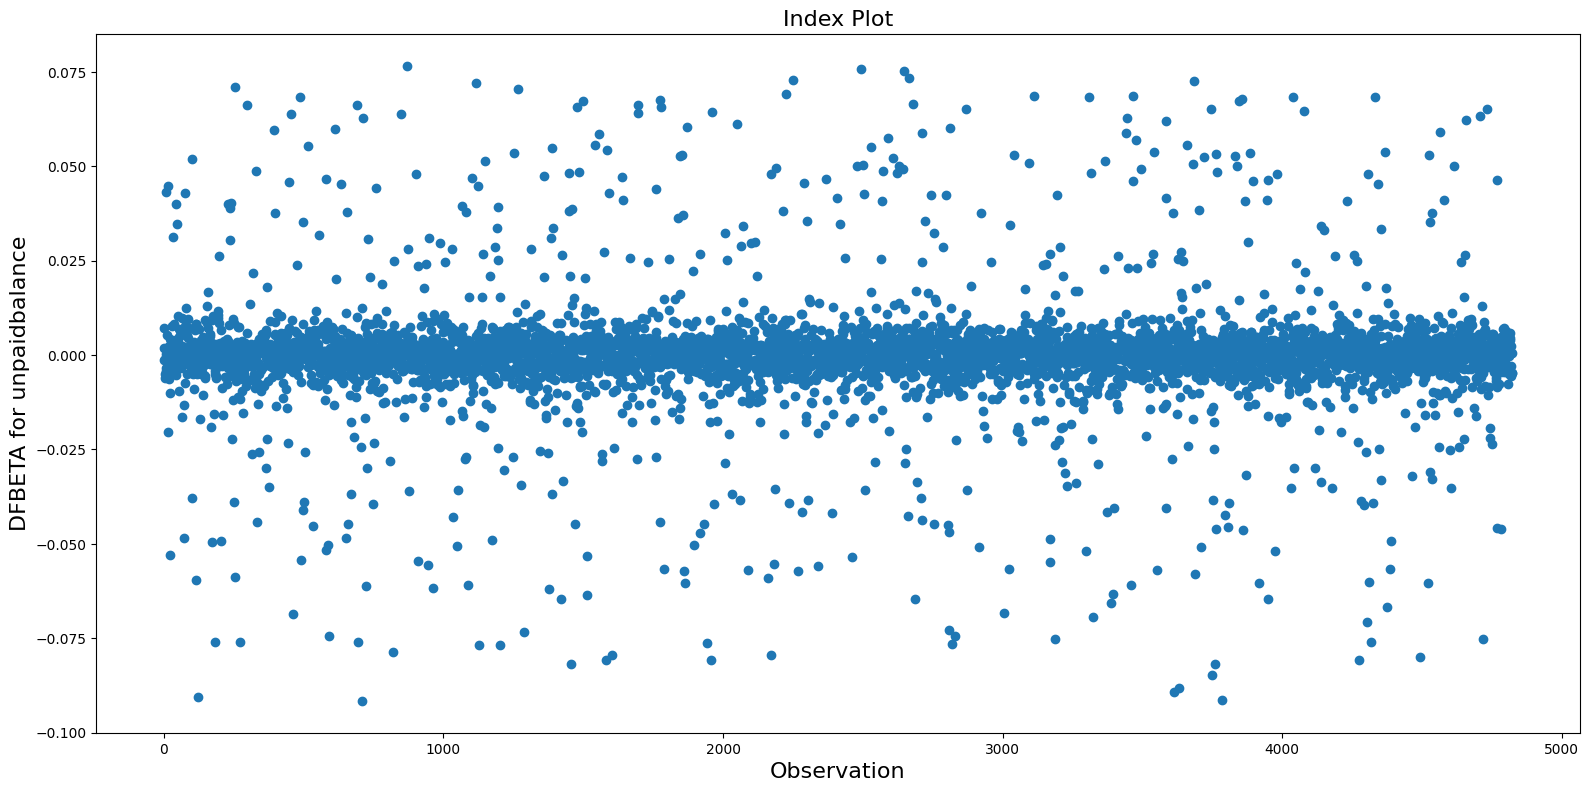

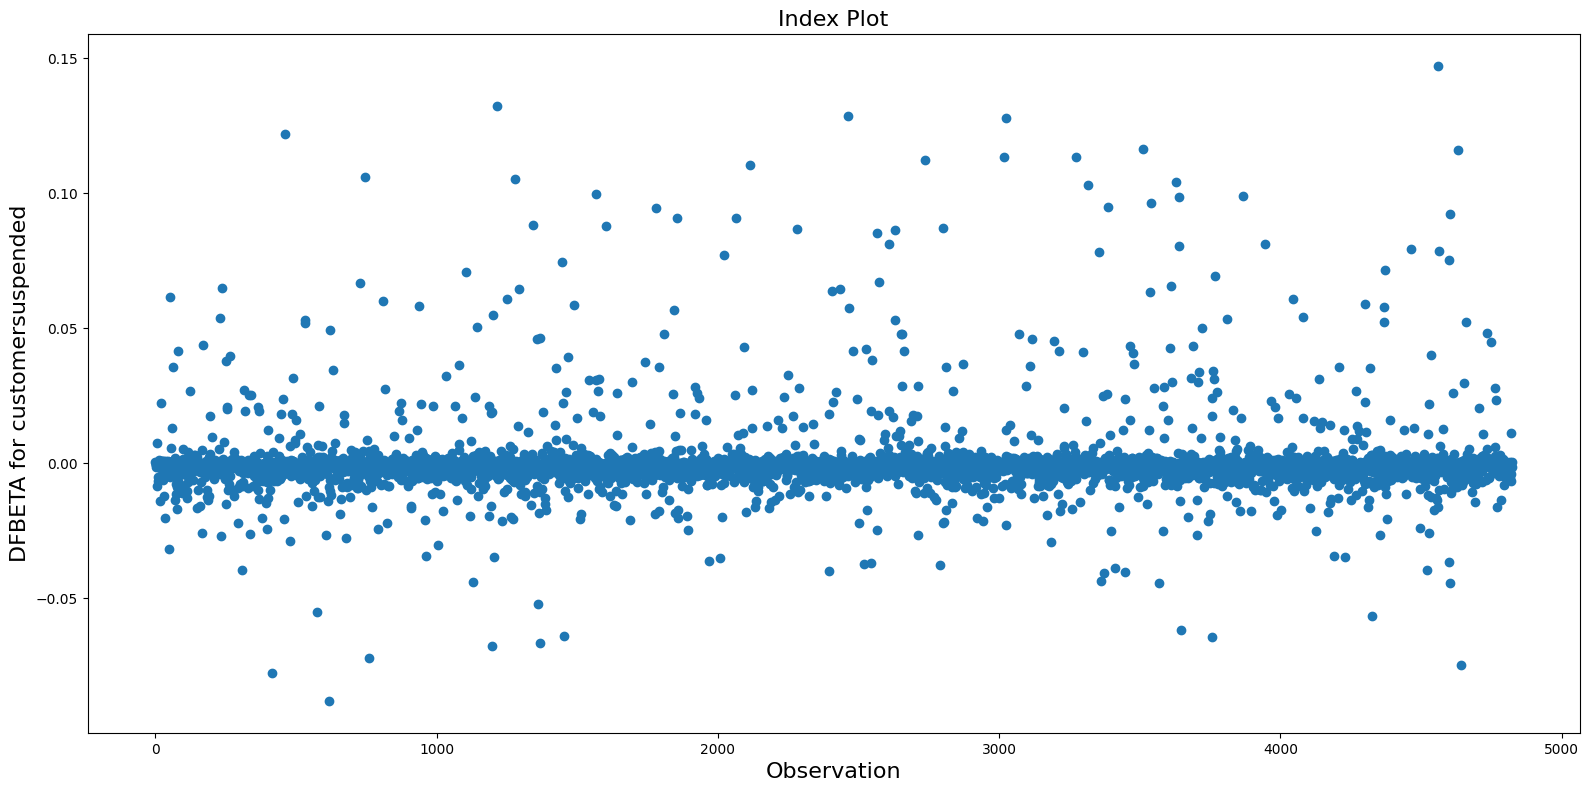

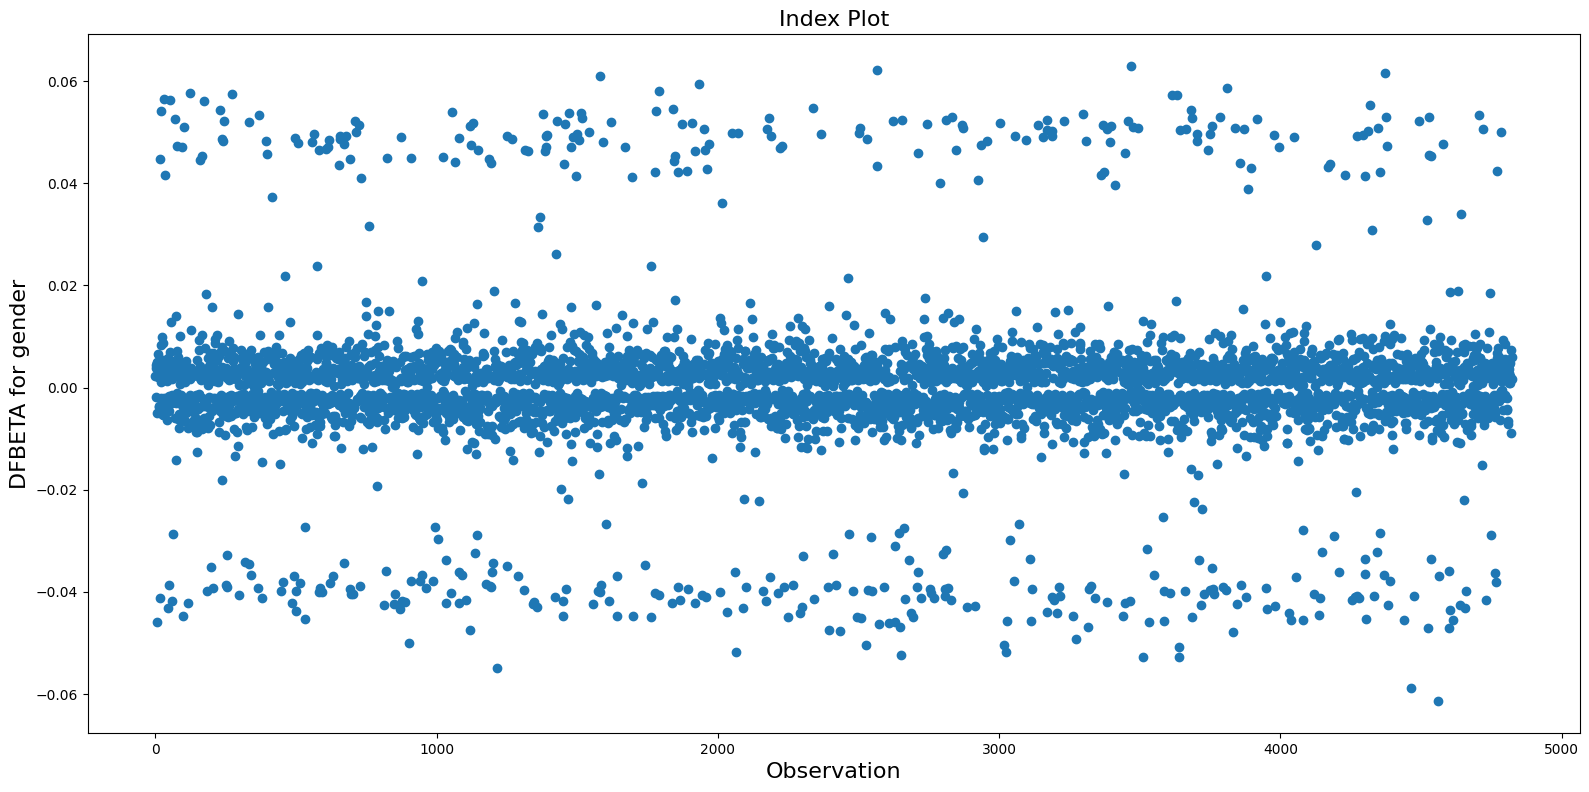

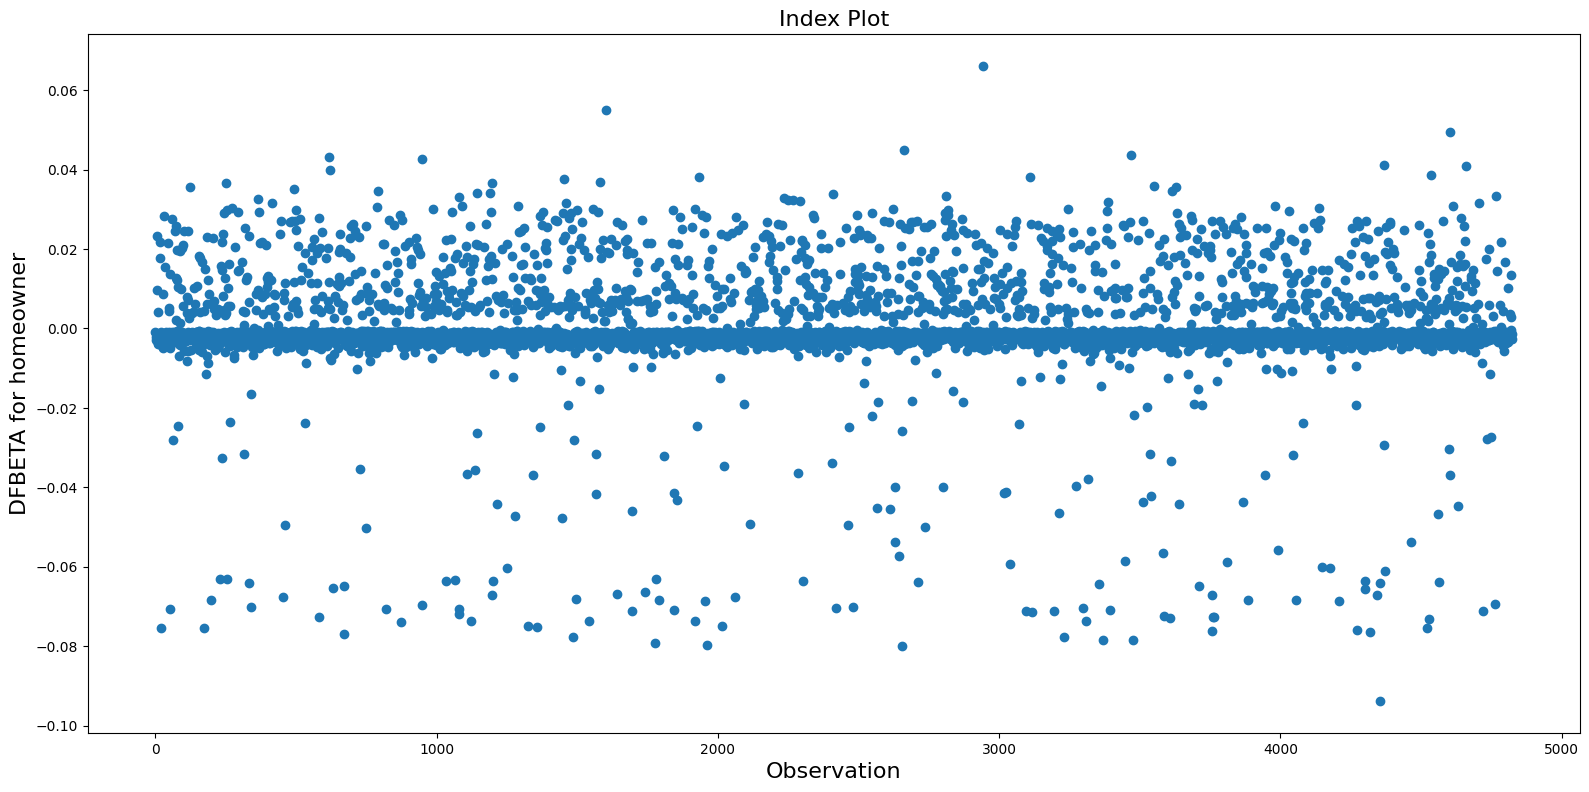

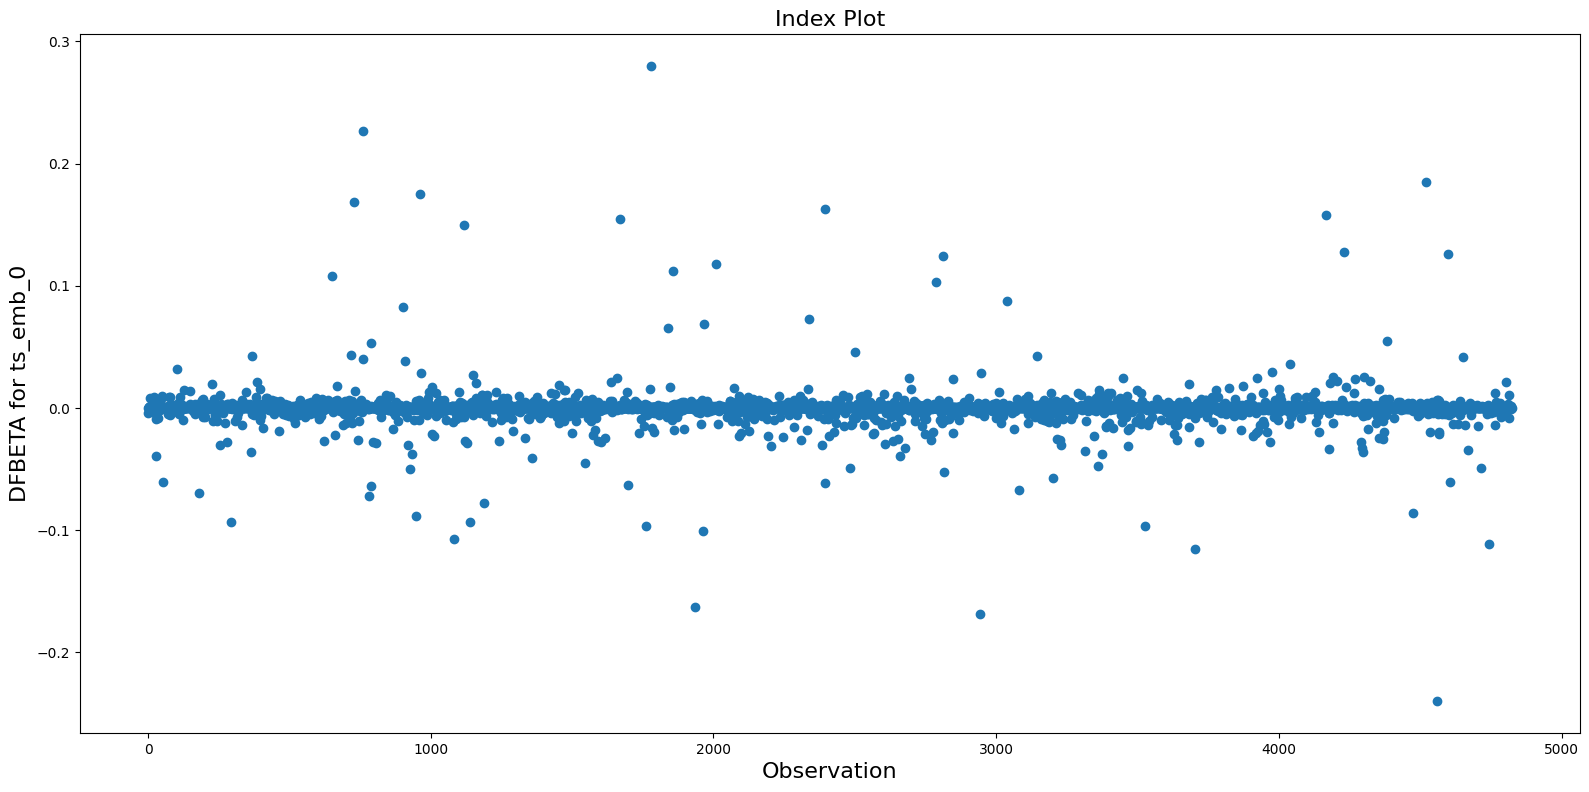

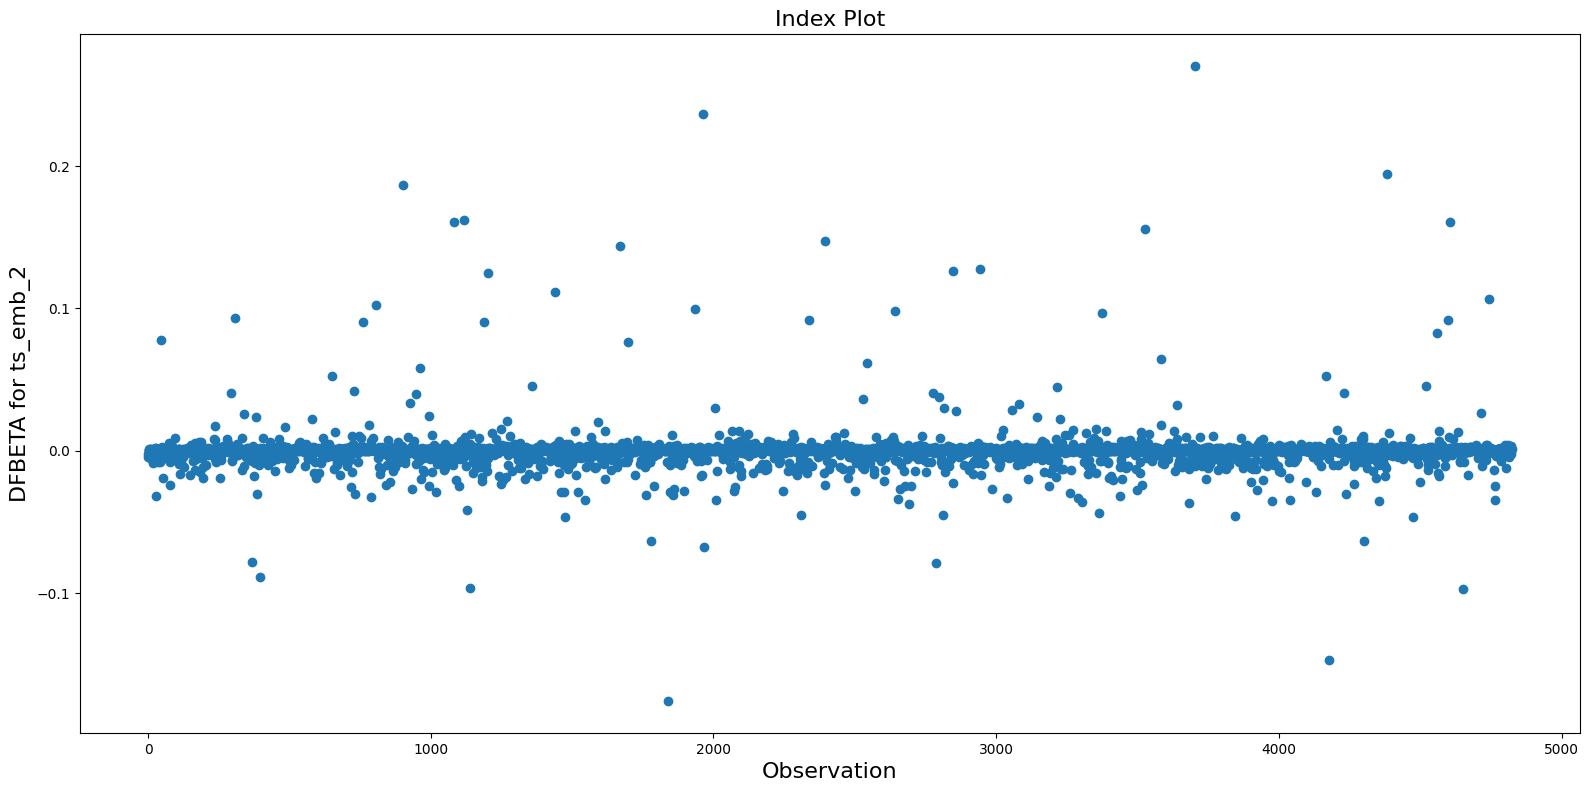

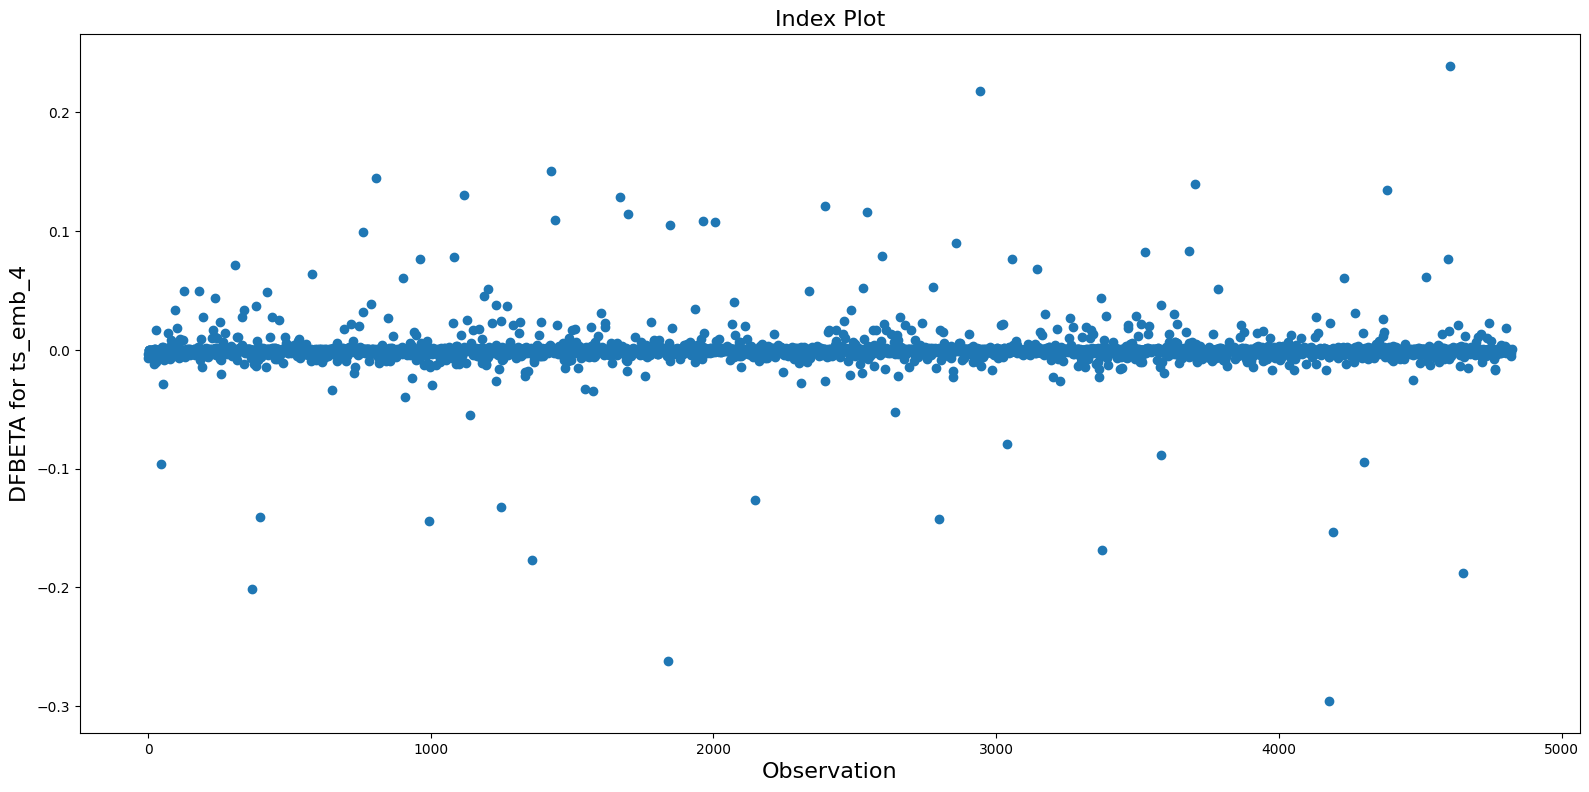

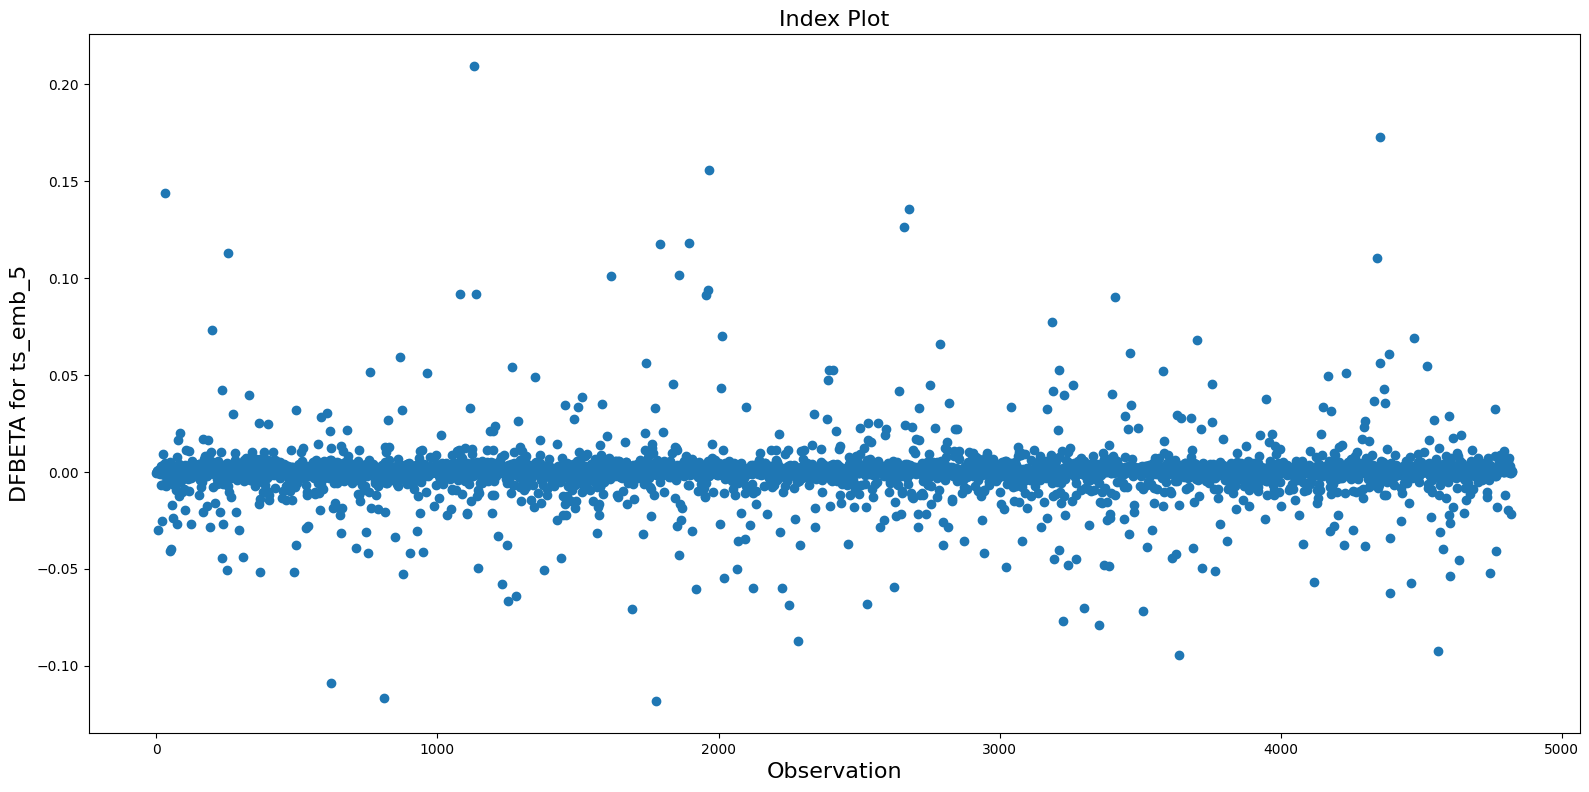

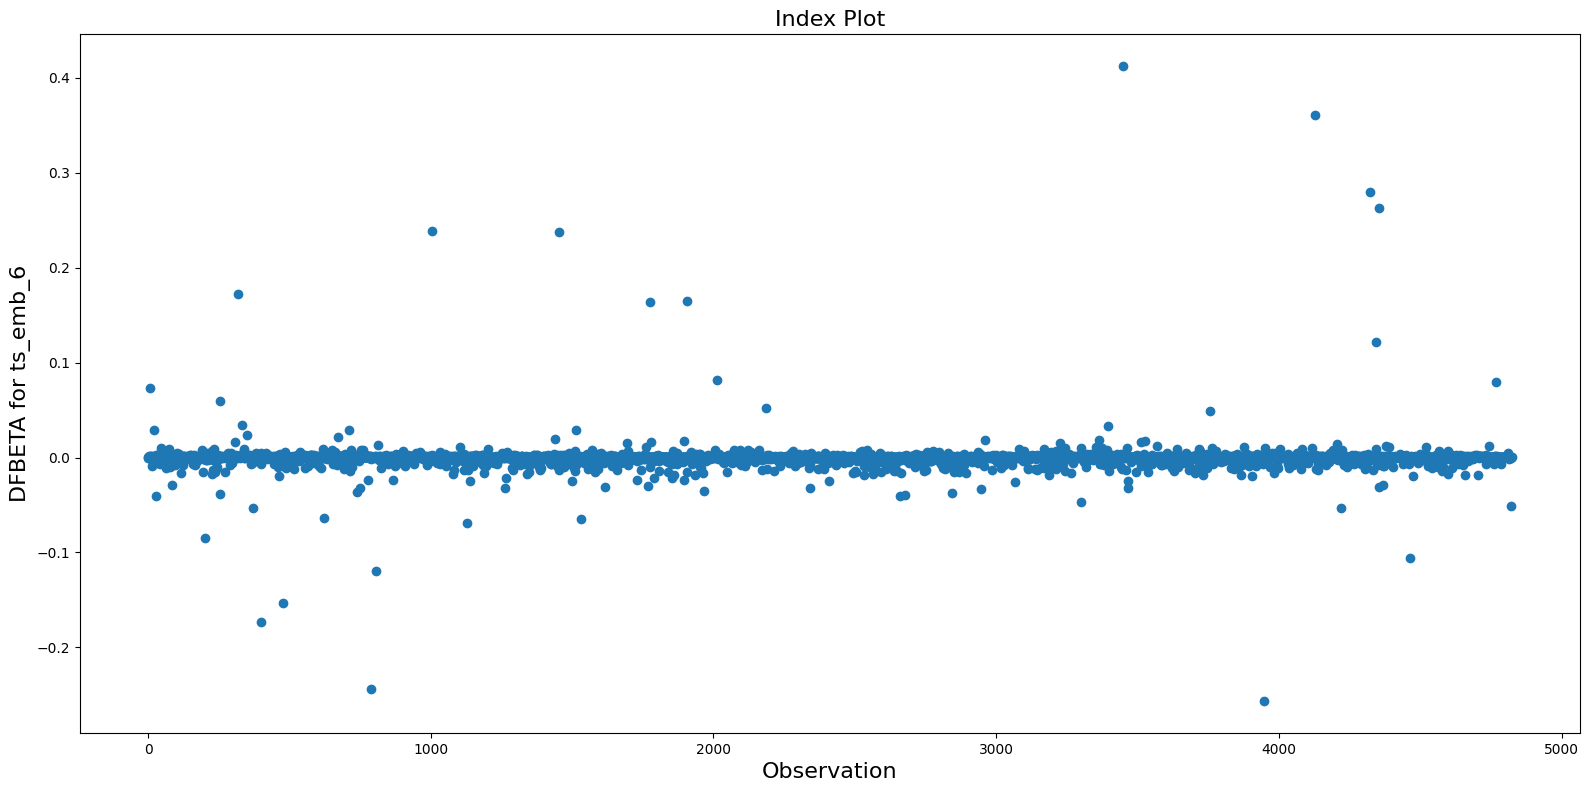

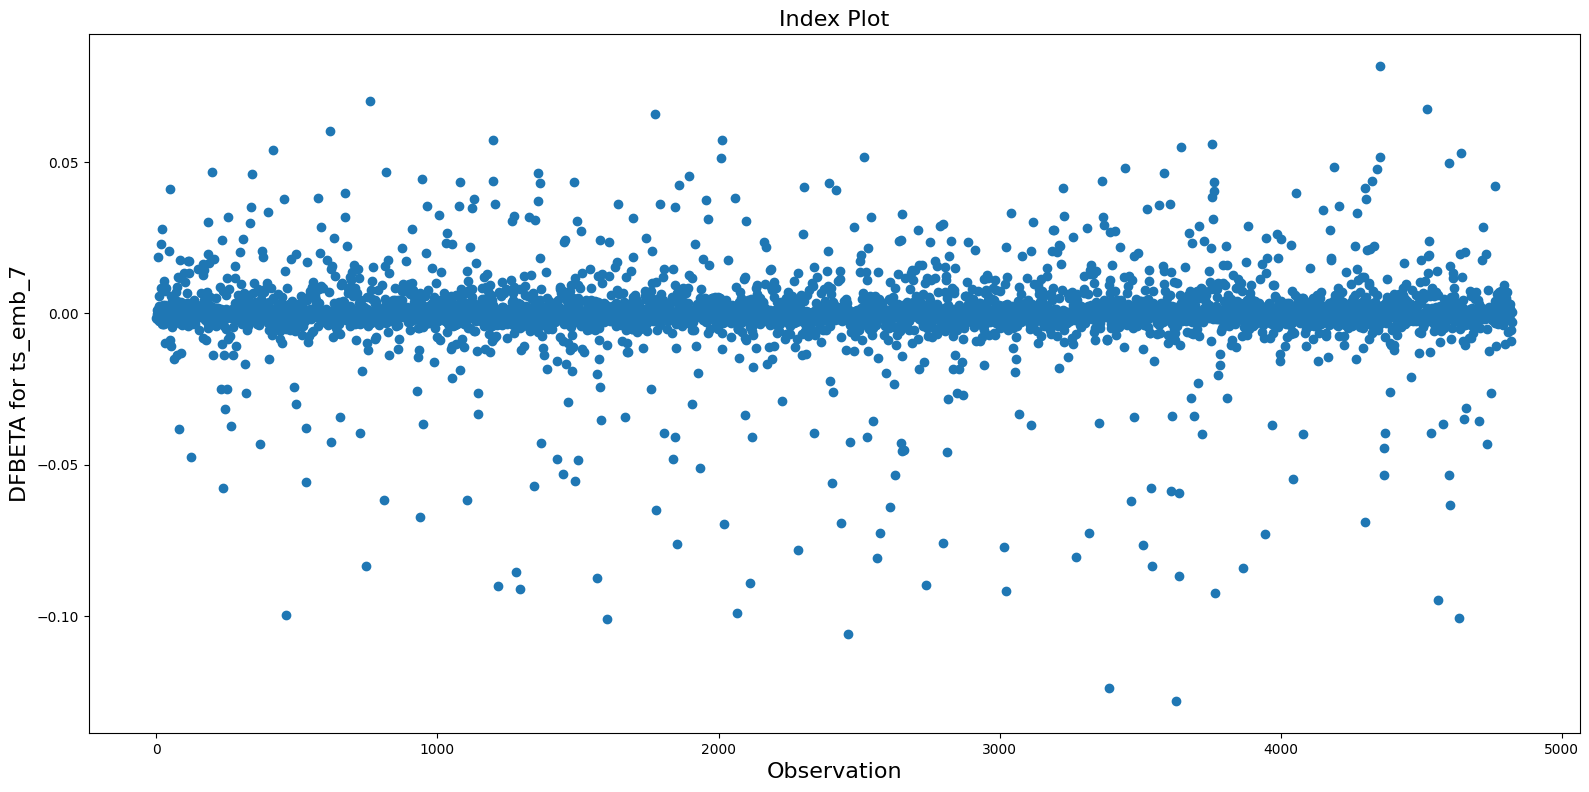

In [91]:
for i in range(len(features_GLM)):
  fig = infl.plot_index(y_var="dfbeta", idx=i, threshold=0.5)
  fig.tight_layout(pad=1.0)


#### 4.1.7. Сохранение модели

In [92]:
save = True
if save:
  file_name = f'model_GLM_auc_{str(max(aucs_glm))[2:6]}.joblib'
  model = models_glm[np.argmax(aucs_glm)]
  joblib.dump(model,  PATH + 'models/' + file_name)

  print(file_name)

model_GLM_auc_7678.joblib


In [93]:
selected_models.append(file_name)

### 4.2. GLM + Random Forest

In [94]:
def get_random_forest_results(idx_test, X_rf, y_rf, train, features_rf):
  rf = RandomForestRegressor(max_depth=6, random_state=25)
  rf.fit(X_rf, y_rf)
  y_pred_rf = rf.predict(train.loc[idx_test, features_rf])

  return y_pred_rf, rf

#### 4.2.1. Отбор признаков

In [95]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits)
X = train
ind = train.index
X['intercept'] = 1
y = train[TARGET_NAME]

aucs_glm_rf = []
selected = pd.DataFrame(index=cols)
for fold, (idx_train, idx_test) in enumerate(cv.split(X, y)):
    idx_train, idx_test = ind[idx_train], ind[idx_test]
    model = models_glm[fold]
    y_pred = model.predict(X.loc[idx_test, features_GLM])

    y_rf = y[idx_train] - model.predict(X.loc[idx_train, features_GLM])
    X_rf = train.loc[idx_train, cols]
    y_pred_rf, rf = get_random_forest_results(idx_test, X_rf, y_rf, train, cols)

    r = permutation_importance(rf, X_rf, y_rf, n_repeats=30, random_state=0)
    selected_rf = []
    for i in r.importances_mean.argsort()[::-1]:
      if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        selected_rf.append(cols[i])
    selected.loc[:, f'{fold}'] = 0
    selected.loc[selected_rf, f'{fold}'] = 1

    y_pred += y_pred_rf
    aucs_glm_rf.append(roc_auc_score(y[idx_test], y_pred))

df_auc['GLM with RF'] = aucs_glm_rf

auc_mean = np.array(aucs_glm_rf).mean()
auc_std = np.array(aucs_glm_rf).std()
print(f'\nauc: {round(auc_mean, 4)} +/- {round(auc_std, 4)}')


auc: 0.742 +/- 0.0301


In [96]:
selected[selected.mean(axis=1) < 1]

,0,1,2,3,4,5,6,7,8,9


#### 4.2.2. Кросс-валидация

In [97]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits)

X = train
y = train[TARGET_NAME]
features_rf = selected[selected.mean(axis=1) == 1].index.tolist()

models_glm_rf = []
aucs_glm_rf = []
for fold, (idx_train, idx_test) in enumerate(cv.split(X, y)):
    idx_train, idx_test = ind[idx_train], ind[idx_test]

    model = models_glm[fold]
    y_pred = model.predict(X.loc[idx_test, features_GLM])

    y_rf = y[idx_train] - model.predict(X.loc[idx_train, features_GLM])
    X_rf = train.loc[idx_train, features_rf]
    y_pred_rf, rf = get_random_forest_results(idx_test, X_rf, y_rf, train, features_rf)

    y_pred += y_pred_rf
    results.loc[idx_test, 'GLM RF'] = y_pred
    models_glm_rf.append(rf)
    aucs_glm_rf.append(roc_auc_score(y[idx_test], y_pred))

df_auc['GLM with RF'] = aucs_glm_rf

auc_mean = np.array(aucs_glm_rf).mean()
auc_std = np.array(aucs_glm_rf).std()
print(f'\nauc: {round(auc_mean, 4)} +/- {round(auc_std, 4)}')


auc: 0.742 +/- 0.0301


#### 4.2.3. Area Under the Curve (AUC)

In [98]:
df_auc.round(4)

,GLM,GLM with RF
0,0.6979,0.7210
1,0.7328,0.7780
2,0.7223,0.7424
3,0.7126,0.7635
4,0.6714,0.7409
5,0.6603,0.7183
6,0.6425,0.6779
7,0.7019,0.7630
8,0.7293,0.7326
9,0.7678,0.7828


In [99]:
df_auc.max().sort_values()

GLM            0.767802
GLM with RF    0.782830
dtype: float64

* Бустинг из GLM Random Forest существенно улучшил результаты

#### 4.2.4. Random Forest feature importances

In [100]:
df = pd.DataFrame(
  index=models_glm_rf[np.argmax(aucs_glm_rf)].feature_names_in_.tolist(),
  columns=['importances']
)
df['importances'] = models_glm_rf[np.argmax(aucs_glm_rf)].feature_importances_
df.sort_values('importances', ascending=False)


,importances
customersuspended,0.250430
age,0.111748
ts_emb_7,0.100001
ts_emb_6,0.077331
ts_emb_5,0.051962
unpaidbalance,0.050552
ts_emb_3,0.044984
ts_emb_4,0.043119
ts_emb_0,0.042300
ts_emb_1,0.040726


#### 4.2.5. Сохранение модели

In [101]:
save = True
if save:
  file_name = f'model_GLM_rf_auc_{str(max(aucs_glm_rf))[2:6]}.joblib'
  model = models_glm_rf[np.argmax(aucs_glm_rf)]
  joblib.dump(model,  PATH + 'models/' + file_name)

  print(file_name)

model_GLM_rf_auc_7828.joblib


In [102]:
selected_models.append(file_name)

### 4.3. Комментарии

* Бустинг из GLM и Random Forest ожидаемо дает лучшие результаты чем базваая модель Random Forest.
* GLM модель обладает более высокой интерпретируемостью, но если результаты модели более важны, чем ее интерпретируемость, имеет смысл поэксперементировать с нейросетями.
* В качестве финальной модели предлагается нейросетевая модель с блоком LSTM, ембеддингами признаков state, occupation, education, объединенных с блоком признаков, отобранных в пункте 3.3.